## Model Training

**Overview**

In this notebook, we embark on the development of a predictive model aimed at forecasting energy output from renewable sources, including wind farms and solar stations in China. The complexity of predicting energy output necessitates an ensemble approach employing several advanced machine learning techniques, each chosen for its unique strengths in handling time-series data and modeling complex relationships.

**Machine Learning Techniques Employed**

- **Recurrent Neural Networks (RNN)**: Used to model the sequential dependencies inherent in time-series data.
- **Long Short-Term Memory (LSTM) Networks**: Enhance prediction accuracy by effectively capturing temporal sequence information.
- **Gradient Boosting Machines (GBM)**: Chosen for their ability to discover complex, nonlinear interactions within datasets.
- **Random Forests**: Provide robustness and excel in managing diverse datasets.
- **Gated Recurrent Unit (GRU) Networks**: Selected for their efficiency in learning from extensive time series data, especially relevant in modeling the volatile patterns seen in renewable energy production.

**Model Validation**

To ensure the robustness and reliability of our predictive models, we implement cross-validation techniques aimed at minimizing overfitting and maximizing generalizability. The performance of our models is assessed using comprehensive metrics such as Mean Absolute Error (MAE), Mean Squared Error (MSE), and the Coefficient of Determination (R²).

**Environmental Impact Assessment**

Our commitment to sustainability is underscored by an environmental impact assessment conducted using the CodeCarbon tool. This tool evaluates the carbon emissions resulting from our computational activities, taking into account factors like energy consumption, the geographic location of computation resources, and the duration of model training.


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
from codecarbon import EmissionsTracker

In [4]:
# upload the data from .xslx files
# Load all the datasets
wf_datasets = []
ss_datasets = []

for i in range(1, 7):  # 6 wind farm sites
    wf_datasets.append(pd.read_excel(f'../renewable_energy_data/data_processed/WF_site{i}_processed.xlsx').drop(index=0))

for i in range(1, 9):  # 8 solar station sites
    ss_datasets.append(pd.read_excel(f'../renewable_energy_data/data_processed/SS_site{i}_processed.xlsx').drop(index=0))

for wfdf in wf_datasets:
    wfdf.columns = ['time','WS_10','WD_10','WS_30','WD_30','WS_50','WD_50','WS_cen','WD_cen','Air_T','Air_P','Air_H','Power(MW)']
for ssdf in ss_datasets:
    ssdf.columns = ['time','TSI','DNI','GHI','Air_T','Air_P','Air_H','Power(MW)']
# Combine all wind farm datasets into one dataframe
combined_wf = pd.concat(wf_datasets, ignore_index=True)

# Combine all solar station datasets into one dataframe
combined_ss = pd.concat(ss_datasets, ignore_index=True)



In [5]:

combined_wf.head()


time  WS_10    WD_10  WS_30   WD_30  WS_50    WD_50  WS_cen  \
0  2019-01-01 00:30:00  2.193  109.903  2.313  84.688  2.344   89.100   2.350   
1  2019-01-01 00:45:00  2.654  109.903  2.494  74.939  2.574   87.267   2.808   
2  2019-01-01 01:00:00  2.249  109.903  2.192  91.140  2.558   96.900   2.924   
3  2019-01-01 01:15:00  1.974  109.903  1.980  91.921  2.049   97.000   2.137   
4  2019-01-01 01:30:00  2.220  109.903  2.336  98.886  2.408  110.533   2.506   

    WD_cen   Air_T    Air_P   Air_H  Power(MW)  
0   78.550 -13.766  889.942  76.981   0.296306  
1   82.733 -13.691  889.675  76.821   0.187590  
2   92.967 -13.447  890.025  74.571   0.081005  
3  100.133 -13.983  889.692  71.808   0.189721  
4  103.000 -14.014  889.967  70.816   0.265041

In [6]:
combined_ss.head()

time  TSI  DNI  GHI  Air_T  Air_P  Air_H  Power(MW)
0  2019-01-01 00:30:00  0.0  0.0  0.0  -11.4  930.5   39.0        0.0
1  2019-01-01 00:45:00  0.0  0.0  0.0  -11.5  930.5   38.0        0.0
2  2019-01-01 01:00:00  0.0  0.0  0.0  -11.5  930.4   38.9        0.0
3  2019-01-01 01:15:00  0.0  0.0  0.0  -11.8  930.1   39.6        0.0
4  2019-01-01 01:30:00  0.0  0.0  0.0  -11.4  930.0   39.4        0.0

In [7]:
# Drop the original 'Time' column
combined_wf = combined_wf.drop('time', axis=1)
combined_ss = combined_ss.drop('time', axis=1)

#### Feature Selection For Wind Farm Sites

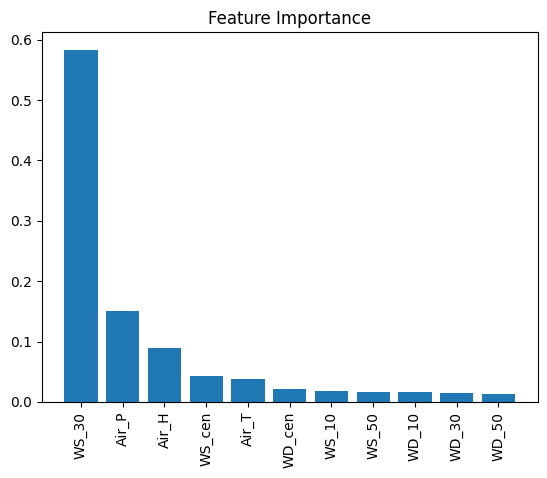

In [9]:
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot as plt
import numpy as np
# Assuming 'Power (MW)' is the target variable
target = 'Power(MW)'
features = combined_wf.columns.drop('Power(MW)')

X_wf = combined_wf[features]
y_wf = combined_wf[target]

# Initialize the Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100)

# Fit the model
rf.fit(X_wf, y_wf)

# Get feature importance
importances = rf.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [features[i] for i in indices]

# Plot the feature importances
plt.figure()
plt.title("Feature Importance")
plt.bar(range(X_wf.shape[1]), importances[indices])
plt.xticks(range(X_wf.shape[1]), names, rotation=90)
plt.show()

Here are some observations:

- **Wind Speed at Height of 30 Meters**: This feature has the highest importance score by a considerable margin. This suggests that wind speed at this height is the most significant predictor of power output within the model. It’s likely that this variable closely relates to the efficiency of wind turbines, which typically align with the hub height of the turbines.

- **Atmosphere (Pressure)**: Atmospheric pressure seems to have the second-highest importance, though much less than wind speed. Pressure can affect wind turbine performance, but its impact is generally considered less direct than wind speed.

- **Relative Humidity**: Humidity has some importance in the model, which might indicate that atmospheric moisture levels can influence wind turbine efficiency or the density of the air, which in turn affects power generation.

- **Wind Speed at the Height of Wheel Hub**: It is somewhat surprising to see this feature with lower importance than wind speed at 30 meters, given that power output is usually most directly related to the wind speed at the hub height. This could be due to the specific design of the turbines in the dataset or interactions between features that the model has captured.

- **Other Features**: The remaining features, such as wind speed and direction at different heights, air temperature, and wind direction at the wheel hub, have relatively low importance scores. This could be due to a few reasons:
  - These features might not have a strong direct relationship with the power output.
  - There could be redundancy among the features; for example, wind speeds at various heights might be highly correlated, and the model finds one (wind speed at 30 meters) to be the most informative.
  - The model might not be capturing complex interactions well if it's not configured or tuned properly, or if these features truly have a minor impact on power output compared to wind speed at 30 meters.

#### RandomForest Training for Wind Farm Sites

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

features = ['WS_30', 'Air_P', 'Air_H']
target = 'Power(MW)'

# Prepare the feature matrix (X) and target vector (y)
X = combined_wf[features]
y = combined_wf[target]

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=123)

# Initialize the model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict on the validation set
y_pred = model.predict(X_val)

mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

# Printing out the scores
print(f'Validation MSE: {mse}')
print(f'Validation RMSE: {rmse}')
print(f'Validation MAE: {mae}')
print(f'Validation R^2: {r2}')

Validation MSE: 262.35276126062604
Validation RMSE: 16.19730722251776
Validation MAE: 9.507719771723886
Validation R^2: 0.806132624453451


In [11]:

features = ['WS_30','WD_50','WS_cen','Air_T','Air_P','Air_H']
target = 'Power(MW)'

# Prepare the feature matrix (X) and target vector (y)
X = combined_wf[features]
y = combined_wf[target]

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=123)

# Initialize the model
model = RandomForestRegressor(n_estimators=100, random_state=123)

# Train the model
model.fit(X_train, y_train)

# Predict on the validation set
y_pred = model.predict(X_val)

mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

# Printing out the scores
print(f'Validation MSE: {mse}')
print(f'Validation RMSE: {rmse}')
print(f'Validation MAE: {mae}')
print(f'Validation R^2: {r2}')

Validation MSE: 136.3572707506356
Validation RMSE: 11.677211599976923
Validation MAE: 6.229906728161221
Validation R^2: 0.8992378578746701


In [12]:
features = ['WS_10','WD_10','WS_30','WD_30','WS_50','WD_50','WS_cen','WD_cen','Air_T','Air_P','Air_H']
target = 'Power(MW)'

# Prepare the feature matrix (X) and target vector (y)
X = combined_wf[features]
y = combined_wf[target]

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=123)

# Initialize the model
model = RandomForestRegressor(n_estimators=100, random_state=123)

# Train the model
model.fit(X_train, y_train)

# Predict on the validation set
y_pred = model.predict(X_val)

mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

# Printing out the scores
print(f'Validation MSE: {mse}')
print(f'Validation RMSE: {rmse}')
print(f'Validation MAE: {mae}')
print(f'Validation R^2: {r2}')

Validation MSE: 128.38734046536715
Validation RMSE: 11.330813760068919
Validation MAE: 6.0228439742291595
Validation R^2: 0.905127292619971


The model with the smaller set of features ('WS_30', 'Air_P', 'Air_H'):

MSE: 261.513
RMSE: 16.171
MAE: 9.469
R^2: 0.806
The model with the more comprehensive set of features:

MSE: 128.528
RMSE: 11.337
MAE: 6.028
R^2: 0.905
The second model, which uses more features, performs better on all metrics. The RMSE is lower, which suggests that the model's predictions are generally closer to the true values. The MAE, which gives a direct interpretation of the average error magnitude, is also lower. The R^2 value is higher, which implies a better fit to the data; this model explains a greater proportion of the variance in the target variable.

This comparison indicates that including more relevant features can improve the model's predictive capabilities. The exact selection of features should be guided by domain knowledge, feature importance scores, and potentially iterative model refinement using techniques like cross-validation. The improved metrics for the second model suggest that factors like wind speed and direction at different heights are important predictors for the power output of wind farms.

#### LSTM Training for Wind Farm Sites

In [43]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

features = ['WS_10','WD_10','WS_30','WD_30','WS_50','WD_50','WS_cen','WD_cen','Air_T','Air_P','Air_H']  # Example features, adjust as needed
target = 'Power(MW)'

# Normalize the features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(combined_wf[features].values)
scaled_target = scaler.fit_transform(combined_wf[[target]].values)

# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(scaled_features, scaled_target, test_size=0.2, shuffle=False)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


/Users/yangyilin/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [15]:
# Manual training loop
batch_size = 32
for epoch in range(30):  # Runs 30 epochs
    for i in range(0, len(X_train), batch_size):
        end = i + batch_size
        batch_x, batch_y = X_train[i:end], y_train[i:end]
        model.train_on_batch(batch_x, batch_y)
    
    # Evaluation at the end of each epoch using predictions
    y_pred = model.predict(X_val, verbose=0)
    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)

    print(f"Epoch {epoch + 1}, MSE: {mse}, RMSE: {rmse}, MAE: {mae}, R2: {r2}")


Epoch 1, MSE: 0.003651338122895599, RMSE: 0.06042630323704735, MAE: 0.04754861217102086, R2: 0.3848722313175542
Epoch 2, MSE: 0.0020919686751531864, RMSE: 0.04573804406785654, MAE: 0.033718088275710024, R2: 0.6475735798797877
Epoch 3, MSE: 0.0016590252218762248, RMSE: 0.04073113332423031, MAE: 0.02832265917798791, R2: 0.7205100024778504
Epoch 4, MSE: 0.0016788431213974975, RMSE: 0.04097368815956769, MAE: 0.028445550435689564, R2: 0.7171713523988414
Epoch 5, MSE: 0.0017292087391391749, RMSE: 0.04158375571228716, MAE: 0.029010739469221097, R2: 0.70868643837089
Epoch 6, MSE: 0.0017718813863253228, RMSE: 0.042093721459682355, MAE: 0.029477908625519147, R2: 0.7014975313554608
Epoch 7, MSE: 0.0018084131526699566, RMSE: 0.042525441240155955, MAE: 0.02978132215346593, R2: 0.6953431563944854
Epoch 8, MSE: 0.0018408169249257268, RMSE: 0.04290474245262086, MAE: 0.02998199555224068, R2: 0.6898842097141985
Epoch 9, MSE: 0.0018702335134042343, RMSE: 0.043246196519511795, MAE: 0.0301286467363736, R2:

Trends Observed:

1. Over the 30 epochs, all performance metrics improve. Specifically, MSE, RMSE, and MAE decrease, indicating that the model's predictions are becoming closer to the actual data points. The R² value increases, suggesting that the model explains a greater proportion of the variance in the dataset over training iterations.
2. The consistent improvement across epochs without any apparent plateau suggests that further gains might be possible with additional training epochs or further tuning of the model's architecture and hyperparameters.
3. The decrease in MAE alongside MSE and RMSE improvements reinforces the model's increasing reliability in predicting wind power output.

The training output shows that LSTM model is effectively learning from the data, as evidenced by decreasing loss metrics and increasing R² values across epochs. The model's ability to better fit the data with each epoch indicates successful learning dynamics. However, the computational cost and time might be a concern, which could potentially be addressed by optimizing the model architecture or the training process. Consider testing with different network architectures or further tuning hyperparameters to potentially enhance performance or reduce training time. Additionally, verifying the model's performance on a completely independent test set would be crucial to ensure that it generalizes well to new data.

##### Hyperparameter Tunning

In [44]:
from tensorflow import keras
from keras_tuner import RandomSearch

def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units1', min_value=32, max_value=512, step=32),
                   input_shape=(X_train.shape[1], X_train.shape[2]),
                   return_sequences=True))
    model.add(LSTM(units=hp.Int('units2', min_value=32, max_value=512, step=32), return_sequences=False))
    model.add(Dense(1))
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
                  loss='mean_squared_error')
    return model
# Hyperparameter tuner setup
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,  # Number of variations on hyperparameters
    executions_per_trial=1,  # Runs per variation
    directory='my_dir',
    project_name='hparam_tuning')

# Running the hyperparameter search
tuner.search(X_train, y_train,
             epochs=30,
             batch_size=32,
             validation_data=(X_val, y_val))

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The optimal number of units in the first LSTM layer is {best_hps.get('units1')} and
the optimal number of units in the second LSTM layer is {best_hps.get('units2')}.
The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")

# Rebuild the model with the best hyperparameters and train it
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val), batch_size=32)



Reloading Tuner from my_dir/hparam_tuning/tuner0.json

The optimal number of units in the first LSTM layer is 256 and
the optimal number of units in the second LSTM layer is 384.
The optimal learning rate for the optimizer is 0.01.

Epoch 1/30
10527/10527 ━━━━━━━━━━━━━━━━━━━━ 52s 5ms/step - loss: 0.0077 - val_loss: 0.0047
Epoch 2/30
10527/10527 ━━━━━━━━━━━━━━━━━━━━ 52s 5ms/step - loss: 0.0045 - val_loss: 0.0039
Epoch 3/30
10527/10527 ━━━━━━━━━━━━━━━━━━━━ 50s 5ms/step - loss: 0.0040 - val_loss: 0.0039
Epoch 4/30
10527/10527 ━━━━━━━━━━━━━━━━━━━━ 50s 5ms/step - loss: 0.0038 - val_loss: 0.0044
Epoch 5/30
10527/10527 ━━━━━━━━━━━━━━━━━━━━ 49s 5ms/step - loss: 0.0036 - val_loss: 0.0048
Epoch 6/30
10527/10527 ━━━━━━━━━━━━━━━━━━━━ 49s 5ms/step - loss: 0.0035 - val_loss: 0.0039
Epoch 7/30
10527/10527 ━━━━━━━━━━━━━━━━━━━━ 49s 5ms/step - loss: 0.0035 - val_loss: 0.0040
Epoch 8/30
10527/10527 ━━━━━━━━━━━━━━━━━━━━ 49s 5ms/step - loss: 0.0034 - val_loss: 0.0040
Epoch 9/30
10527/10527 ━━━━━━━━━━━━━━━━

The output from the LSTM model training after hyperparameter tuning shows that the model has been trained with optimal settings obtained from keras-tuner. Here are the key takeaways from the training output:

**Training Process**
The optimal hyperparameters found are 256 units in the first LSTM layer, 384 units in the second LSTM layer, and a learning rate of 0.01.
The training process consisted of 30 epochs, with the loss reducing over time, indicating that the model was learning from the training data.

**Epoch by Epoch Analysis**
Initial Reduction in Loss: The model quickly reduced its training and validation loss in the first few epochs, suggesting that the chosen learning rate and LSTM configuration were effective at capturing the underlying patterns in the data.
Validation Loss Fluctuations: While the training loss consistently decreased, the validation loss experienced fluctuations. This could indicate overfitting, where the model learns patterns specific to the training data that do not generalize well to the validation data.
Stabilization of Loss: Towards the later epochs, both training and validation losses started to stabilize, although with occasional increases in validation loss.

**Concerns and Observations**
Overfitting: The occasional increase in validation loss suggests that the model might be overfitting to the training data. This is also supported by the decrease in training loss concurrent with increases or plateaus in validation loss.
Early Stopping: Implementing early stopping could potentially prevent overfitting by halting the training process when the validation loss begins to rise or fails to improve significantly.

**Recommendations**
1. Early Stopping: Consider using an early stopping callback in the training process to halt training when the validation loss fails to improve, helping prevent overfitting.
2. Adjust Learning Rate: If overfitting persists, experiment with lowering the learning rate or implementing learning rate schedules or decay.
3. Regularization Techniques: Introduce regularization methods like Dropout or L2 regularization to the LSTM layers to reduce overfitting.
4. Validation Loss Monitoring: Continue to monitor validation loss closely. If it begins to increase while training loss decreases, further tweaks to the model or its training regimen might be necessary.

Overall, the LSTM model is performing well in terms of learning from the training data, but careful attention should be paid to ensure that it generalizes well to unseen data, maintaining a balance between training and validation performance.

In [50]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

features = ['WS_10', 'WD_10', 'WS_30', 'WD_30', 'WS_50', 'WD_50', 'WS_cen', 'WD_cen', 'Air_T', 'Air_P', 'Air_H']
target = 'Power(MW)'

# Normalize the features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(combined_wf[features].values)
scaled_target = scaler.fit_transform(combined_wf[[target]].values)

# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(scaled_features, scaled_target, test_size=0.2, shuffle=False)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))

# Define the LSTM model
model = Sequential()
model.add(LSTM(256, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(384, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mean_squared_error')

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)

# Modify the file extension for saving the model
model_checkpoint = ModelCheckpoint('./model/wf_best_model.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=1)

# Train the model
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_val, y_val), 
                    callbacks=[early_stopping, model_checkpoint], verbose=1)

# Load the best model weights
model.load_weights('./model/wf_best_model.keras')

# Predict and evaluate
y_pred = model.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f"Final MSE: {mse}")
print(f"Final RMSE: {rmse}")
print(f"Final MAE: {mae}")
print(f"Final R^2: {r2}")


Epoch 1/30


/Users/yangyilin/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10527/10527 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0076
Epoch 1: val_loss improved from inf to 0.00668, saving model to ./model/wf_best_model.keras
10527/10527 ━━━━━━━━━━━━━━━━━━━━ 56s 5ms/step - loss: 0.0076 - val_loss: 0.0067
Epoch 2/30
10523/10527 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0048
Epoch 2: val_loss improved from 0.00668 to 0.00554, saving model to ./model/wf_best_model.keras
10527/10527 ━━━━━━━━━━━━━━━━━━━━ 52s 5ms/step - loss: 0.0048 - val_loss: 0.0055
Epoch 3/30
10518/10527 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043
Epoch 3: val_loss improved from 0.00554 to 0.00410, saving model to ./model/wf_best_model.keras
10527/10527 ━━━━━━━━━━━━━━━━━━━━ 52s 5ms/step - loss: 0.0043 - val_loss: 0.0041
Epoch 4/30
10524/10527 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0039
Epoch 4: val_loss did not improve from 0.00410
10527/10527 ━━━━━━━━━━━━━━━━━━━━ 53s 5ms/step - loss: 0.0039 - val_loss: 0.0059
Epoch 5/30
10518/10527 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0039
Epoch

**Performance Metrics Review**:
   - **MSE (Mean Squared Error)**: The final MSE of 0.0041 indicates a low average squared error between predicted and actual values. However, the actual impact depends on the scale of your target variable (Power in MW).
   - **RMSE (Root Mean Squared Error)**: An RMSE of 0.064 suggests that the typical prediction error magnitude is about 0.064 MW. Whether this is acceptable depends on the typical output ranges and the precision needs of your application.
   - **MAE (Mean Absolute Error)**: A MAE of 0.048 MW shows that, on average, the model's predictions are off by approximately 0.048 MW. This can be a useful measure to understand error without squaring effects.
   - **R² (Coefficient of Determination)**: An R² of 0.608 implies that about 60.8% of the variability in your power output is explained by the model. This is moderate and suggests that the model has captured a significant portion of the relationship between features and target but still leaves a substantial portion unexplained.

#### Gradient Boosting Machines (GBM) with XGBoost For Wind Farm Sites

In [54]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Assuming 'Power (MW)' is the target variable for combined_wf
target_wf = 'Power(MW)'
features_wf = combined_wf.drop(columns=[target_wf]).columns

X_wf = combined_wf[features_wf]
y_wf = combined_wf[target_wf]

# Split the data into training and testing sets
X_wf_train, X_wf_test, y_wf_train, y_wf_test = train_test_split(X_wf, y_wf, test_size=0.2, random_state=42)

# Initialize XGBoost regressor
xg_reg_wf = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, seed=42)

# Train the model
xg_reg_wf.fit(X_wf_train, y_wf_train)

# Predictions
y_wf_pred = xg_reg_wf.predict(X_wf_test)

# Evaluation
mse_wf = mean_squared_error(y_wf_test, y_wf_pred)
mae_wf = mean_absolute_error(y_wf_test, y_wf_pred)
r2_wf = r2_score(y_wf_test, y_wf_pred)

print(f'Wind Farm GBM MSE: {mse_wf}, MAE: {mae_wf}, R^2: {r2_wf}')


Wind Farm GBM MSE: 163.08473298505893, MAE: 7.078716988191593, R^2: 0.8788343898451381


In [62]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Assuming 'Power (MW)' is the target variable for combined_wf
target_wf = 'Power(MW)'
features_wf = combined_wf.drop(columns=[target_wf]).columns

X_wf = combined_wf[features_wf]
y_wf = combined_wf[target_wf]

# Split the data into training and testing sets
X_wf_train, X_wf_test, y_wf_train, y_wf_test = train_test_split(X_wf, y_wf, test_size=0.2, random_state=42)

# Initialize XGBoost regressor
xg_reg_wf = xgb.XGBRegressor(objective='reg:squarederror', seed=42)

# Define the parameter grid
param_grid = {
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'n_estimators': [50, 100, 200],
    'subsample': [0.5, 0.7, 1.0],
    'colsample_bytree': [0.5, 0.7, 1.0]
}

# Initialize the GridSearchCV object
grid_search = GridSearchCV(estimator=xg_reg_wf, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, verbose=1)

# Fit the grid search to the data
grid_search.fit(X_wf_train, y_wf_train)

# Best parameters
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Output the best parameters and the best score
print(f'Best parameters found: {best_params}')
print(f'Best RMSE from grid search: {abs(best_score)**0.5}')


Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Best parameters found: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 9, 'n_estimators': 200, 'subsample': 1.0}
Best RMSE from grid search: 11.907957755644667


In [63]:
# Initialize XGBoost regressor with the best parameters
optimized_xg_reg_wf = xgb.XGBRegressor(
    objective='reg:squarederror',
    colsample_bytree=1.0,
    learning_rate=0.2,
    max_depth=9,
    n_estimators=200,
    subsample=1.0,
    seed=42
)

# Train the model on the entire training dataset
optimized_xg_reg_wf.fit(X_wf_train, y_wf_train)

# Predict on the test set
optimized_y_wf_pred = optimized_xg_reg_wf.predict(X_wf_test)

# Evaluation
optimized_mse_wf = mean_squared_error(y_wf_test, optimized_y_wf_pred)
optimized_mae_wf = mean_absolute_error(y_wf_test, optimized_y_wf_pred)
optimized_r2_wf = r2_score(y_wf_test, optimized_y_wf_pred)

print(f'Optimized Wind Farm GBM MSE: {optimized_mse_wf}, MAE: {optimized_mae_wf}, R^2: {optimized_r2_wf}')


Optimized Wind Farm GBM MSE: 132.12941841336206, MAE: 6.261306556939944, R^2: 0.9018329839438203


Here are the results from applying Gradient Boosting Machines (GBM) with XGBoost to wind farm site data for energy prediction:

1. **Initial Model:**
   - **Mean Squared Error (MSE):** 163.08
   - **Mean Absolute Error (MAE):** 7.08
   - **R² Score:** 0.88

2. **Optimized Model via Grid Search:**
   - **Best Parameters:** `{'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 9, 'n_estimators': 200, 'subsample': 1.0}`
   - **Best RMSE from Grid Search:** 11.91
   - **Optimized MSE:** 132.13
   - **Optimized MAE:** 6.26
   - **Optimized R² Score:** 0.90

These results show that the optimized model, after tuning the hyperparameters, achieved better accuracy and lower error values, which indicates a more effective model for predicting power output from the wind farm sites.

The relatively high MSE in the optimized model does suggest that there might be room for improvement. While the optimized model does show an enhancement in predicting power output from wind farms (with a higher R² value of 0.90 indicating a better fit to the data), the MSE indicates that the model's predictions are still somewhat off from the actual values.

#### RNN Model for Wind Farm (combined_wf)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Example features and target
features = ['WS_10','WD_10','WS_30','WD_30','WS_50','WD_50','WS_cen','WD_cen','Air_T','Air_P','Air_H'] 
target = 'Power(MW)'

# Data preparation
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(combined_wf[features].values)
scaled_target = scaler.fit_transform(combined_wf[[target]].values)

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(scaled_features, scaled_target, test_size=0.2, random_state=42)

# Reshaping input data for RNN
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Model configuration
model = Sequential()
model.add(SimpleRNN(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Model training
model.fit(X_train, y_train, epochs=500, batch_size=32, verbose=2)

# Prediction and evaluation
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse}, RMSE: {rmse}, MAE: {mae}, R^2: {r2}')


Epoch 1/500


/Users/yangyilin/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[codecarbon INFO @ 01:45:32] Energy consumed for RAM : 0.000450 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:45:32] Energy consumed for all CPUs : 0.003189 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:45:32] 0.003639 kWh of electricity used since the beginning.


10527/10527 - 4s - 344us/step - loss: 0.0091
Epoch 2/500
10527/10527 - 3s - 302us/step - loss: 0.0071
Epoch 3/500
10527/10527 - 3s - 305us/step - loss: 0.0066
Epoch 4/500


[codecarbon INFO @ 01:45:41] Energy consumed for RAM : 0.147976 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:45:41] Energy consumed for all CPUs : 1.048272 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:45:41] 1.196249 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:45:41] Energy consumed for RAM : 0.149147 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:45:41] Energy consumed for RAM : 0.148824 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:45:41] Energy consumed for all CPUs : 1.056587 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:45:41] Energy consumed for all CPUs : 1.054298 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:45:41] 1.203121 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:45:41] 1.205734 kWh of electricity used since the beginning.


10527/10527 - 3s - 323us/step - loss: 0.0061
Epoch 5/500
10527/10527 - 3s - 303us/step - loss: 0.0059
Epoch 6/500


[codecarbon INFO @ 01:45:47] Energy consumed for RAM : 0.000475 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:45:47] Energy consumed for all CPUs : 0.003366 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:45:47] 0.003841 kWh of electricity used since the beginning.


10527/10527 - 3s - 301us/step - loss: 0.0058
Epoch 7/500
10527/10527 - 3s - 295us/step - loss: 0.0058
Epoch 8/500
10527/10527 - 3s - 301us/step - loss: 0.0057
Epoch 9/500


[codecarbon INFO @ 01:45:56] Energy consumed for RAM : 0.148001 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:45:56] Energy consumed for RAM : 0.148849 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:45:56] Energy consumed for all CPUs : 1.048449 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:45:56] Energy consumed for all CPUs : 1.054475 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:45:56] 1.196450 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:45:56] 1.203323 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:45:56] Energy consumed for RAM : 0.149171 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:45:56] Energy consumed for all CPUs : 1.056764 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:45:56] 1.205936 kWh of electricity used since the beginning.


10527/10527 - 3s - 297us/step - loss: 0.0056
Epoch 10/500
10527/10527 - 3s - 296us/step - loss: 0.0056
Epoch 11/500


[codecarbon INFO @ 01:46:02] Energy consumed for RAM : 0.000500 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:46:02] Energy consumed for all CPUs : 0.003543 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:46:02] 0.004043 kWh of electricity used since the beginning.


10527/10527 - 3s - 294us/step - loss: 0.0055
Epoch 12/500
10527/10527 - 3s - 302us/step - loss: 0.0054
Epoch 13/500


[codecarbon INFO @ 01:46:11] Energy consumed for RAM : 0.148874 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:46:11] Energy consumed for RAM : 0.148026 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:46:11] Energy consumed for all CPUs : 1.054652 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:46:11] Energy consumed for all CPUs : 1.048626 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:46:11] 1.203525 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:46:11] 1.196653 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:46:11] Energy consumed for RAM : 0.149196 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:46:11] Energy consumed for all CPUs : 1.056941 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:46:11] 1.206138 kWh of electricity used since the beginning.


10527/10527 - 3s - 300us/step - loss: 0.0053
Epoch 14/500
10527/10527 - 3s - 303us/step - loss: 0.0053
Epoch 15/500


[codecarbon INFO @ 01:46:17] Energy consumed for RAM : 0.000525 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:46:17] Energy consumed for all CPUs : 0.003720 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:46:17] 0.004245 kWh of electricity used since the beginning.


10527/10527 - 3s - 302us/step - loss: 0.0052
Epoch 16/500
10527/10527 - 3s - 293us/step - loss: 0.0052
Epoch 17/500
10527/10527 - 3s - 301us/step - loss: 0.0051
Epoch 18/500


[codecarbon INFO @ 01:46:26] Energy consumed for RAM : 0.148899 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:46:26] Energy consumed for RAM : 0.148051 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:46:26] Energy consumed for all CPUs : 1.054829 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:46:26] 1.203727 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:46:26] Energy consumed for all CPUs : 1.048803 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:46:26] 1.196855 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:46:26] Energy consumed for RAM : 0.149221 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:46:26] Energy consumed for all CPUs : 1.057118 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:46:26] 1.206340 kWh of electricity used since the beginning.


10527/10527 - 3s - 305us/step - loss: 0.0051
Epoch 19/500
10527/10527 - 3s - 299us/step - loss: 0.0051
Epoch 20/500


[codecarbon INFO @ 01:46:32] Energy consumed for RAM : 0.000550 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:46:32] Energy consumed for all CPUs : 0.003897 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:46:32] 0.004447 kWh of electricity used since the beginning.


10527/10527 - 3s - 301us/step - loss: 0.0050
Epoch 21/500
10527/10527 - 3s - 304us/step - loss: 0.0050
Epoch 22/500
10527/10527 - 3s - 292us/step - loss: 0.0050
Epoch 23/500


[codecarbon INFO @ 01:46:41] Energy consumed for RAM : 0.148924 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:46:41] Energy consumed for RAM : 0.148076 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:46:41] Energy consumed for all CPUs : 1.055006 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:46:41] Energy consumed for all CPUs : 1.048980 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:46:41] 1.197057 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:46:41] 1.203930 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:46:41] Energy consumed for RAM : 0.149247 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:46:41] Energy consumed for all CPUs : 1.057296 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:46:41] 1.206542 kWh of electricity used since the beginning.


10527/10527 - 3s - 301us/step - loss: 0.0050
Epoch 24/500
10527/10527 - 3s - 301us/step - loss: 0.0049
Epoch 25/500


[codecarbon INFO @ 01:46:47] Energy consumed for RAM : 0.000575 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:46:47] Energy consumed for all CPUs : 0.004074 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:46:47] 0.004649 kWh of electricity used since the beginning.


10527/10527 - 3s - 307us/step - loss: 0.0049
Epoch 26/500
10527/10527 - 3s - 302us/step - loss: 0.0049
Epoch 27/500
10527/10527 - 3s - 302us/step - loss: 0.0049
Epoch 28/500


[codecarbon INFO @ 01:46:56] Energy consumed for RAM : 0.148949 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:46:56] Energy consumed for RAM : 0.148101 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:46:56] Energy consumed for all CPUs : 1.055183 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:46:56] Energy consumed for all CPUs : 1.049158 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:46:56] 1.204132 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:46:56] 1.197259 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:46:56] Energy consumed for RAM : 0.149271 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:46:56] Energy consumed for all CPUs : 1.057473 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:46:56] 1.206744 kWh of electricity used since the beginning.


10527/10527 - 3s - 302us/step - loss: 0.0048
Epoch 29/500
10527/10527 - 3s - 292us/step - loss: 0.0048
Epoch 30/500


[codecarbon INFO @ 01:47:02] Energy consumed for RAM : 0.000600 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:47:02] Energy consumed for all CPUs : 0.004251 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:47:02] 0.004852 kWh of electricity used since the beginning.


10527/10527 - 3s - 294us/step - loss: 0.0048
Epoch 31/500
10527/10527 - 3s - 293us/step - loss: 0.0047
Epoch 32/500


[codecarbon INFO @ 01:47:11] Energy consumed for RAM : 0.148974 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:47:11] Energy consumed for RAM : 0.148126 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:47:11] Energy consumed for all CPUs : 1.055360 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:47:11] Energy consumed for all CPUs : 1.049335 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:47:11] 1.204334 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:47:11] 1.197461 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:47:11] Energy consumed for RAM : 0.149296 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:47:11] Energy consumed for all CPUs : 1.057650 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:47:11] 1.206946 kWh of electricity used since the beginning.


10527/10527 - 3s - 300us/step - loss: 0.0047
Epoch 33/500
10527/10527 - 3s - 286us/step - loss: 0.0046
Epoch 34/500
10527/10527 - 3s - 293us/step - loss: 0.0046
Epoch 35/500


[codecarbon INFO @ 01:47:17] Energy consumed for RAM : 0.000625 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:47:17] Energy consumed for all CPUs : 0.004429 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:47:17] 0.005054 kWh of electricity used since the beginning.


10527/10527 - 3s - 290us/step - loss: 0.0046
Epoch 36/500
10527/10527 - 3s - 291us/step - loss: 0.0046
Epoch 37/500


[codecarbon INFO @ 01:47:26] Energy consumed for RAM : 0.148999 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:47:26] Energy consumed for RAM : 0.148151 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:47:26] Energy consumed for all CPUs : 1.055537 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:47:26] 1.204536 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:47:26] Energy consumed for all CPUs : 1.049512 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:47:26] 1.197663 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:47:26] Energy consumed for RAM : 0.149322 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:47:26] Energy consumed for all CPUs : 1.057827 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:47:26] 1.207148 kWh of electricity used since the beginning.


10527/10527 - 3s - 290us/step - loss: 0.0046
Epoch 38/500
10527/10527 - 3s - 303us/step - loss: 0.0045
Epoch 39/500


[codecarbon INFO @ 01:47:32] Energy consumed for RAM : 0.000650 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:47:32] Energy consumed for all CPUs : 0.004606 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:47:32] 0.005256 kWh of electricity used since the beginning.


10527/10527 - 3s - 301us/step - loss: 0.0045
Epoch 40/500
10527/10527 - 3s - 292us/step - loss: 0.0045
Epoch 41/500
10527/10527 - 3s - 297us/step - loss: 0.0045
Epoch 42/500


[codecarbon INFO @ 01:47:41] Energy consumed for RAM : 0.148176 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:47:41] Energy consumed for RAM : 0.149024 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:47:41] Energy consumed for all CPUs : 1.055714 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:47:41] Energy consumed for all CPUs : 1.049689 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:47:41] 1.204738 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:47:41] 1.197865 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:47:41] Energy consumed for RAM : 0.149347 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:47:41] Energy consumed for all CPUs : 1.058004 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:47:41] 1.207351 kWh of electricity used since the beginning.


10527/10527 - 3s - 304us/step - loss: 0.0045
Epoch 43/500
10527/10527 - 3s - 294us/step - loss: 0.0045
Epoch 44/500


[codecarbon INFO @ 01:47:47] Energy consumed for RAM : 0.000675 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:47:47] Energy consumed for all CPUs : 0.004783 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:47:47] 0.005458 kWh of electricity used since the beginning.


10527/10527 - 3s - 294us/step - loss: 0.0045
Epoch 45/500
10527/10527 - 3s - 303us/step - loss: 0.0045
Epoch 46/500
10527/10527 - 3s - 296us/step - loss: 0.0045
Epoch 47/500


[codecarbon INFO @ 01:47:56] Energy consumed for RAM : 0.149049 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:47:56] Energy consumed for RAM : 0.148201 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:47:56] Energy consumed for all CPUs : 1.055892 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:47:56] 1.204940 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:47:56] Energy consumed for all CPUs : 1.049866 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:47:56] 1.198067 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:47:56] Energy consumed for RAM : 0.149372 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:47:56] Energy consumed for all CPUs : 1.058181 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:47:56] 1.207553 kWh of electricity used since the beginning.


10527/10527 - 3s - 305us/step - loss: 0.0044
Epoch 48/500
10527/10527 - 3s - 291us/step - loss: 0.0044
Epoch 49/500


[codecarbon INFO @ 01:48:02] Energy consumed for RAM : 0.000700 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:48:02] Energy consumed for all CPUs : 0.004960 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:48:02] 0.005660 kWh of electricity used since the beginning.


10527/10527 - 3s - 298us/step - loss: 0.0044
Epoch 50/500
10527/10527 - 3s - 296us/step - loss: 0.0044
Epoch 51/500
10527/10527 - 3s - 297us/step - loss: 0.0044
Epoch 52/500


[codecarbon INFO @ 01:48:11] Energy consumed for RAM : 0.148226 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:48:11] Energy consumed for RAM : 0.149074 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:48:11] Energy consumed for all CPUs : 1.050043 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:48:11] 1.198269 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:48:11] Energy consumed for all CPUs : 1.056069 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:48:11] 1.205142 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:48:11] Energy consumed for RAM : 0.149397 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:48:11] Energy consumed for all CPUs : 1.058358 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:48:11] 1.207755 kWh of electricity used since the beginning.


10527/10527 - 3s - 302us/step - loss: 0.0044
Epoch 53/500
10527/10527 - 3s - 296us/step - loss: 0.0044
Epoch 54/500


[codecarbon INFO @ 01:48:17] Energy consumed for RAM : 0.000725 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:48:17] Energy consumed for all CPUs : 0.005137 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:48:17] 0.005862 kWh of electricity used since the beginning.


10527/10527 - 3s - 301us/step - loss: 0.0044
Epoch 55/500
10527/10527 - 3s - 293us/step - loss: 0.0044
Epoch 56/500


[codecarbon INFO @ 01:48:26] Energy consumed for RAM : 0.148251 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:48:26] Energy consumed for RAM : 0.149099 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:48:26] Energy consumed for all CPUs : 1.050220 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:48:26] Energy consumed for all CPUs : 1.056246 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:48:26] 1.205344 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:48:26] 1.198472 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:48:26] Energy consumed for RAM : 0.149422 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:48:26] Energy consumed for all CPUs : 1.058535 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:48:26] 1.207957 kWh of electricity used since the beginning.


10527/10527 - 3s - 302us/step - loss: 0.0044
Epoch 57/500
10527/10527 - 3s - 294us/step - loss: 0.0044
Epoch 58/500
10527/10527 - 3s - 294us/step - loss: 0.0044
Epoch 59/500


[codecarbon INFO @ 01:48:32] Energy consumed for RAM : 0.000750 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:48:32] Energy consumed for all CPUs : 0.005314 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:48:32] 0.006064 kWh of electricity used since the beginning.


10527/10527 - 3s - 299us/step - loss: 0.0044
Epoch 60/500
10527/10527 - 3s - 296us/step - loss: 0.0044
Epoch 61/500


[codecarbon INFO @ 01:48:41] Energy consumed for RAM : 0.148276 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:48:41] Energy consumed for RAM : 0.149124 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:48:41] Energy consumed for all CPUs : 1.050397 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:48:41] Energy consumed for all CPUs : 1.056423 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:48:41] 1.205546 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:48:41] 1.198674 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:48:41] Energy consumed for RAM : 0.149447 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:48:41] Energy consumed for all CPUs : 1.058713 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:48:41] 1.208159 kWh of electricity used since the beginning.


10527/10527 - 3s - 304us/step - loss: 0.0044
Epoch 62/500
10527/10527 - 3s - 290us/step - loss: 0.0044
Epoch 63/500


[codecarbon INFO @ 01:48:47] Energy consumed for RAM : 0.000775 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:48:47] Energy consumed for all CPUs : 0.005491 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:48:47] 0.006267 kWh of electricity used since the beginning.


10527/10527 - 3s - 289us/step - loss: 0.0043
Epoch 64/500
10527/10527 - 3s - 284us/step - loss: 0.0043
Epoch 65/500
10527/10527 - 3s - 287us/step - loss: 0.0043
Epoch 66/500


[codecarbon INFO @ 01:48:56] Energy consumed for RAM : 0.148301 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:48:56] Energy consumed for RAM : 0.149149 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:48:56] Energy consumed for all CPUs : 1.050574 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:48:56] Energy consumed for all CPUs : 1.056600 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:48:56] 1.198875 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:48:56] 1.205748 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:48:56] Energy consumed for RAM : 0.149472 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:48:56] Energy consumed for all CPUs : 1.058890 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:48:56] 1.208361 kWh of electricity used since the beginning.


10527/10527 - 3s - 293us/step - loss: 0.0043
Epoch 67/500
10527/10527 - 3s - 291us/step - loss: 0.0043
Epoch 68/500


[codecarbon INFO @ 01:49:02] Energy consumed for RAM : 0.000800 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:49:02] Energy consumed for all CPUs : 0.005668 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:49:02] 0.006469 kWh of electricity used since the beginning.


10527/10527 - 3s - 293us/step - loss: 0.0043
Epoch 69/500
10527/10527 - 3s - 291us/step - loss: 0.0043
Epoch 70/500
10527/10527 - 3s - 307us/step - loss: 0.0043
Epoch 71/500


[codecarbon INFO @ 01:49:11] Energy consumed for RAM : 0.148326 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:49:11] Energy consumed for RAM : 0.149174 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:49:11] Energy consumed for all CPUs : 1.050751 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:49:11] Energy consumed for all CPUs : 1.056777 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:49:11] 1.205950 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:49:11] 1.199077 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:49:11] Energy consumed for RAM : 0.149497 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:49:11] Energy consumed for all CPUs : 1.059067 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:49:11] 1.208563 kWh of electricity used since the beginning.


10527/10527 - 3s - 298us/step - loss: 0.0043
Epoch 72/500
10527/10527 - 3s - 300us/step - loss: 0.0043
Epoch 73/500


[codecarbon INFO @ 01:49:18] Energy consumed for RAM : 0.000825 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:49:18] Energy consumed for all CPUs : 0.005846 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:49:18] 0.006671 kWh of electricity used since the beginning.


10527/10527 - 3s - 297us/step - loss: 0.0043
Epoch 74/500
10527/10527 - 3s - 297us/step - loss: 0.0043
Epoch 75/500
10527/10527 - 3s - 292us/step - loss: 0.0043
Epoch 76/500


[codecarbon INFO @ 01:49:26] Energy consumed for RAM : 0.148351 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:49:26] Energy consumed for RAM : 0.149199 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:49:26] Energy consumed for all CPUs : 1.050928 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:49:26] Energy consumed for all CPUs : 1.056954 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:49:26] 1.206152 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:49:26] 1.199279 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:49:26] Energy consumed for RAM : 0.149521 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:49:26] Energy consumed for all CPUs : 1.059244 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:49:26] 1.208765 kWh of electricity used since the beginning.


10527/10527 - 3s - 298us/step - loss: 0.0043
Epoch 77/500
10527/10527 - 3s - 293us/step - loss: 0.0043
Epoch 78/500


[codecarbon INFO @ 01:49:33] Energy consumed for RAM : 0.000850 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:49:33] Energy consumed for all CPUs : 0.006023 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:49:33] 0.006873 kWh of electricity used since the beginning.


10527/10527 - 3s - 294us/step - loss: 0.0043
Epoch 79/500
10527/10527 - 3s - 293us/step - loss: 0.0043
Epoch 80/500
10527/10527 - 3s - 292us/step - loss: 0.0043
Epoch 81/500


[codecarbon INFO @ 01:49:41] Energy consumed for RAM : 0.148376 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:49:41] Energy consumed for RAM : 0.149224 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:49:41] Energy consumed for all CPUs : 1.051105 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:49:41] Energy consumed for all CPUs : 1.057131 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:49:41] 1.206355 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:49:41] 1.199482 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:49:41] Energy consumed for RAM : 0.149546 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:49:41] Energy consumed for all CPUs : 1.059421 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:49:41] 1.208967 kWh of electricity used since the beginning.


10527/10527 - 3s - 297us/step - loss: 0.0043
Epoch 82/500
10527/10527 - 3s - 294us/step - loss: 0.0043
Epoch 83/500


[codecarbon INFO @ 01:49:48] Energy consumed for RAM : 0.000875 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:49:48] Energy consumed for all CPUs : 0.006200 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:49:48] 0.007075 kWh of electricity used since the beginning.


10527/10527 - 3s - 297us/step - loss: 0.0043
Epoch 84/500
10527/10527 - 3s - 290us/step - loss: 0.0043
Epoch 85/500


[codecarbon INFO @ 01:49:56] Energy consumed for RAM : 0.149249 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:49:56] Energy consumed for RAM : 0.148401 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:49:56] Energy consumed for all CPUs : 1.057308 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:49:56] Energy consumed for all CPUs : 1.051282 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:49:56] 1.206557 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:49:56] 1.199684 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:49:56] Energy consumed for RAM : 0.149571 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:49:56] Energy consumed for all CPUs : 1.059598 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:49:56] 1.209170 kWh of electricity used since the beginning.


10527/10527 - 3s - 302us/step - loss: 0.0043
Epoch 86/500
10527/10527 - 3s - 294us/step - loss: 0.0043
Epoch 87/500
10527/10527 - 3s - 291us/step - loss: 0.0043
Epoch 88/500


[codecarbon INFO @ 01:50:03] Energy consumed for RAM : 0.000900 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:50:03] Energy consumed for all CPUs : 0.006377 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:50:03] 0.007277 kWh of electricity used since the beginning.


10527/10527 - 3s - 295us/step - loss: 0.0043
Epoch 89/500
10527/10527 - 3s - 292us/step - loss: 0.0042
Epoch 90/500


[codecarbon INFO @ 01:50:11] Energy consumed for RAM : 0.148426 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:50:11] Energy consumed for RAM : 0.149274 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:50:11] Energy consumed for all CPUs : 1.051459 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:50:11] Energy consumed for all CPUs : 1.057485 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:50:11] 1.206759 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:50:11] 1.199886 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:50:11] Energy consumed for RAM : 0.149596 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:50:11] Energy consumed for all CPUs : 1.059775 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:50:11] 1.209372 kWh of electricity used since the beginning.


10527/10527 - 3s - 297us/step - loss: 0.0043
Epoch 91/500
10527/10527 - 3s - 299us/step - loss: 0.0043
Epoch 92/500


[codecarbon INFO @ 01:50:18] Energy consumed for RAM : 0.000925 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:50:18] Energy consumed for all CPUs : 0.006554 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:50:18] 0.007479 kWh of electricity used since the beginning.


10527/10527 - 3s - 296us/step - loss: 0.0042
Epoch 93/500
10527/10527 - 3s - 293us/step - loss: 0.0042
Epoch 94/500
10527/10527 - 3s - 292us/step - loss: 0.0042
Epoch 95/500


[codecarbon INFO @ 01:50:26] Energy consumed for RAM : 0.148451 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:50:26] Energy consumed for RAM : 0.149299 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:50:26] Energy consumed for all CPUs : 1.051637 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:50:26] 1.200088 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:50:26] Energy consumed for all CPUs : 1.057662 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:50:26] 1.206961 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:50:26] Energy consumed for RAM : 0.149621 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:50:26] Energy consumed for all CPUs : 1.059952 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:50:26] 1.209574 kWh of electricity used since the beginning.


10527/10527 - 3s - 300us/step - loss: 0.0042
Epoch 96/500
10527/10527 - 3s - 294us/step - loss: 0.0042
Epoch 97/500


[codecarbon INFO @ 01:50:33] Energy consumed for RAM : 0.000950 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:50:33] Energy consumed for all CPUs : 0.006731 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:50:33] 0.007681 kWh of electricity used since the beginning.


10527/10527 - 3s - 296us/step - loss: 0.0042
Epoch 98/500
10527/10527 - 3s - 295us/step - loss: 0.0042
Epoch 99/500
10527/10527 - 3s - 293us/step - loss: 0.0042
Epoch 100/500


[codecarbon INFO @ 01:50:41] Energy consumed for RAM : 0.148476 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:50:41] Energy consumed for all CPUs : 1.051814 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:50:41] Energy consumed for RAM : 0.149324 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:50:41] Energy consumed for all CPUs : 1.057840 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:50:41] 1.200290 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:50:41] 1.207163 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:50:41] Energy consumed for RAM : 0.149646 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:50:41] Energy consumed for all CPUs : 1.060129 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:50:41] 1.209776 kWh of electricity used since the beginning.


10527/10527 - 3s - 300us/step - loss: 0.0042
Epoch 101/500
10527/10527 - 3s - 296us/step - loss: 0.0042
Epoch 102/500


[codecarbon INFO @ 01:50:48] Energy consumed for RAM : 0.000975 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:50:48] Energy consumed for all CPUs : 0.006908 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:50:48] 0.007884 kWh of electricity used since the beginning.


10527/10527 - 3s - 294us/step - loss: 0.0042
Epoch 103/500
10527/10527 - 3s - 293us/step - loss: 0.0042
Epoch 104/500
10527/10527 - 3s - 297us/step - loss: 0.0042
Epoch 105/500


[codecarbon INFO @ 01:50:56] Energy consumed for RAM : 0.149349 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:50:56] Energy consumed for all CPUs : 1.058017 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:50:56] 1.207365 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:50:56] Energy consumed for RAM : 0.148501 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:50:56] Energy consumed for all CPUs : 1.051991 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:50:56] 1.200492 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:50:56] Energy consumed for RAM : 0.149671 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:50:56] Energy consumed for all CPUs : 1.060307 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:50:56] 1.209978 kWh of electricity used since the beginning.


10527/10527 - 3s - 296us/step - loss: 0.0042
Epoch 106/500
10527/10527 - 3s - 289us/step - loss: 0.0042
Epoch 107/500


[codecarbon INFO @ 01:51:03] Energy consumed for RAM : 0.001000 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:51:03] Energy consumed for all CPUs : 0.007085 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:51:03] 0.008086 kWh of electricity used since the beginning.


10527/10527 - 3s - 293us/step - loss: 0.0042
Epoch 108/500
10527/10527 - 3s - 291us/step - loss: 0.0042
Epoch 109/500
10527/10527 - 3s - 294us/step - loss: 0.0042
Epoch 110/500


[codecarbon INFO @ 01:51:11] Energy consumed for RAM : 0.149374 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:51:11] Energy consumed for RAM : 0.148526 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:51:11] Energy consumed for all CPUs : 1.052168 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:51:11] 1.200694 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:51:11] Energy consumed for all CPUs : 1.058194 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:51:11] 1.207567 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:51:11] Energy consumed for RAM : 0.149696 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:51:11] Energy consumed for all CPUs : 1.060484 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:51:11] 1.210180 kWh of electricity used since the beginning.


10527/10527 - 3s - 298us/step - loss: 0.0042
Epoch 111/500
10527/10527 - 3s - 293us/step - loss: 0.0042
Epoch 112/500


[codecarbon INFO @ 01:51:18] Energy consumed for RAM : 0.001025 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:51:18] Energy consumed for all CPUs : 0.007263 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:51:18] 0.008288 kWh of electricity used since the beginning.


10527/10527 - 3s - 302us/step - loss: 0.0042
Epoch 113/500
10527/10527 - 3s - 295us/step - loss: 0.0042
Epoch 114/500


[codecarbon INFO @ 01:51:26] Energy consumed for RAM : 0.149399 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:51:26] Energy consumed for RAM : 0.148551 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:51:26] Energy consumed for all CPUs : 1.058371 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:51:26] Energy consumed for all CPUs : 1.052345 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:51:26] 1.207769 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:51:26] 1.200896 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:51:26] Energy consumed for RAM : 0.149721 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:51:26] Energy consumed for all CPUs : 1.060661 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:51:26] 1.210382 kWh of electricity used since the beginning.


10527/10527 - 3s - 300us/step - loss: 0.0042
Epoch 115/500
10527/10527 - 3s - 288us/step - loss: 0.0042
Epoch 116/500
10527/10527 - 3s - 291us/step - loss: 0.0042
Epoch 117/500


[codecarbon INFO @ 01:51:33] Energy consumed for RAM : 0.001050 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:51:33] Energy consumed for all CPUs : 0.007440 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:51:33] 0.008490 kWh of electricity used since the beginning.


10527/10527 - 3s - 294us/step - loss: 0.0042
Epoch 118/500
10527/10527 - 3s - 289us/step - loss: 0.0042
Epoch 119/500


[codecarbon INFO @ 01:51:41] Energy consumed for RAM : 0.149424 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:51:41] Energy consumed for RAM : 0.148576 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:51:41] Energy consumed for all CPUs : 1.058548 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:51:41] Energy consumed for all CPUs : 1.052522 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:51:41] 1.207971 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:51:41] 1.201098 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:51:41] Energy consumed for RAM : 0.149747 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:51:41] Energy consumed for all CPUs : 1.060838 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:51:41] 1.210584 kWh of electricity used since the beginning.


10527/10527 - 3s - 298us/step - loss: 0.0042
Epoch 120/500
10527/10527 - 3s - 293us/step - loss: 0.0042
Epoch 121/500


[codecarbon INFO @ 01:51:48] Energy consumed for RAM : 0.001075 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:51:48] Energy consumed for all CPUs : 0.007617 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:51:48] 0.008692 kWh of electricity used since the beginning.


10527/10527 - 3s - 295us/step - loss: 0.0042
Epoch 122/500
10527/10527 - 3s - 301us/step - loss: 0.0042
Epoch 123/500
10527/10527 - 3s - 292us/step - loss: 0.0042
Epoch 124/500


[codecarbon INFO @ 01:51:56] Energy consumed for RAM : 0.148601 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:51:56] Energy consumed for RAM : 0.149449 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:51:56] Energy consumed for all CPUs : 1.052699 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:51:56] 1.201300 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:51:56] Energy consumed for all CPUs : 1.058725 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:51:56] 1.208173 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:51:56] Energy consumed for RAM : 0.149772 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:51:56] Energy consumed for all CPUs : 1.061015 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:51:56] 1.210786 kWh of electricity used since the beginning.


10527/10527 - 3s - 303us/step - loss: 0.0042
Epoch 125/500
10527/10527 - 3s - 295us/step - loss: 0.0041
Epoch 126/500


[codecarbon INFO @ 01:52:03] Energy consumed for RAM : 0.001100 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:52:03] Energy consumed for all CPUs : 0.007794 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:52:03] 0.008894 kWh of electricity used since the beginning.


10527/10527 - 3s - 294us/step - loss: 0.0042
Epoch 127/500
10527/10527 - 3s - 299us/step - loss: 0.0041
Epoch 128/500
10527/10527 - 3s - 298us/step - loss: 0.0041
Epoch 129/500


[codecarbon INFO @ 01:52:11] Energy consumed for RAM : 0.148626 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:52:11] Energy consumed for RAM : 0.149474 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:52:11] Energy consumed for all CPUs : 1.052876 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:52:11] Energy consumed for all CPUs : 1.058902 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:52:11] 1.201503 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:52:11] 1.208376 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:52:11] Energy consumed for RAM : 0.149797 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:52:11] Energy consumed for all CPUs : 1.061192 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:52:11] 1.210989 kWh of electricity used since the beginning.


10527/10527 - 3s - 300us/step - loss: 0.0041
Epoch 130/500
10527/10527 - 3s - 290us/step - loss: 0.0041
Epoch 131/500


[codecarbon INFO @ 01:52:18] Energy consumed for RAM : 0.001125 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:52:18] Energy consumed for all CPUs : 0.007971 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:52:18] 0.009096 kWh of electricity used since the beginning.


10527/10527 - 3s - 293us/step - loss: 0.0041
Epoch 132/500
10527/10527 - 3s - 293us/step - loss: 0.0041
Epoch 133/500
10527/10527 - 3s - 296us/step - loss: 0.0041
Epoch 134/500


[codecarbon INFO @ 01:52:26] Energy consumed for RAM : 0.148651 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:52:26] Energy consumed for RAM : 0.149499 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:52:26] Energy consumed for all CPUs : 1.059079 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:52:26] Energy consumed for all CPUs : 1.053053 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:52:26] 1.208578 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:52:26] 1.201705 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:52:26] Energy consumed for RAM : 0.149822 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:52:26] Energy consumed for all CPUs : 1.061369 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:52:26] 1.211191 kWh of electricity used since the beginning.


10527/10527 - 3s - 296us/step - loss: 0.0041
Epoch 135/500
10527/10527 - 3s - 290us/step - loss: 0.0041
Epoch 136/500


[codecarbon INFO @ 01:52:33] Energy consumed for RAM : 0.001150 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:52:33] Energy consumed for all CPUs : 0.008148 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:52:33] 0.009298 kWh of electricity used since the beginning.


10527/10527 - 3s - 296us/step - loss: 0.0041
Epoch 137/500
10527/10527 - 3s - 294us/step - loss: 0.0041
Epoch 138/500
10527/10527 - 3s - 289us/step - loss: 0.0041
Epoch 139/500


[codecarbon INFO @ 01:52:41] Energy consumed for RAM : 0.149524 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:52:41] Energy consumed for RAM : 0.148676 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:52:41] Energy consumed for all CPUs : 1.059256 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:52:41] 1.208780 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:52:41] Energy consumed for all CPUs : 1.053230 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:52:41] 1.201907 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:52:41] Energy consumed for RAM : 0.149847 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:52:41] Energy consumed for all CPUs : 1.061546 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:52:41] 1.211393 kWh of electricity used since the beginning.


10527/10527 - 3s - 297us/step - loss: 0.0041
Epoch 140/500
10527/10527 - 3s - 292us/step - loss: 0.0041
Epoch 141/500


[codecarbon INFO @ 01:52:48] Energy consumed for RAM : 0.001175 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:52:48] Energy consumed for all CPUs : 0.008325 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:52:48] 0.009501 kWh of electricity used since the beginning.


10527/10527 - 3s - 296us/step - loss: 0.0041
Epoch 142/500
10527/10527 - 3s - 290us/step - loss: 0.0041
Epoch 143/500


[codecarbon INFO @ 01:52:56] Energy consumed for RAM : 0.149549 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:52:56] Energy consumed for RAM : 0.148701 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:52:56] Energy consumed for all CPUs : 1.059433 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:52:56] Energy consumed for all CPUs : 1.053408 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:52:56] 1.208982 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:52:56] 1.202109 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:52:56] Energy consumed for RAM : 0.149872 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:52:56] Energy consumed for all CPUs : 1.061723 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:52:56] 1.211595 kWh of electricity used since the beginning.


10527/10527 - 3s - 298us/step - loss: 0.0041
Epoch 144/500
10527/10527 - 3s - 289us/step - loss: 0.0041
Epoch 145/500
10527/10527 - 3s - 289us/step - loss: 0.0041
Epoch 146/500


[codecarbon INFO @ 01:53:03] Energy consumed for RAM : 0.001200 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:53:03] Energy consumed for all CPUs : 0.008502 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:53:03] 0.009703 kWh of electricity used since the beginning.


10527/10527 - 3s - 296us/step - loss: 0.0041
Epoch 147/500
10527/10527 - 3s - 293us/step - loss: 0.0041
Epoch 148/500


[codecarbon INFO @ 01:53:11] Energy consumed for RAM : 0.148726 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:53:11] Energy consumed for RAM : 0.149574 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:53:11] Energy consumed for all CPUs : 1.053585 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:53:11] Energy consumed for all CPUs : 1.059611 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:53:11] 1.202311 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:53:11] 1.209184 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:53:11] Energy consumed for RAM : 0.149897 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:53:11] Energy consumed for all CPUs : 1.061901 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:53:11] 1.211797 kWh of electricity used since the beginning.


10527/10527 - 3s - 299us/step - loss: 0.0041
Epoch 149/500
10527/10527 - 3s - 291us/step - loss: 0.0041
Epoch 150/500


[codecarbon INFO @ 01:53:18] Energy consumed for RAM : 0.001225 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:53:18] Energy consumed for all CPUs : 0.008680 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:53:18] 0.009905 kWh of electricity used since the beginning.


10527/10527 - 3s - 295us/step - loss: 0.0041
Epoch 151/500
10527/10527 - 3s - 295us/step - loss: 0.0041
Epoch 152/500
10527/10527 - 3s - 287us/step - loss: 0.0041
Epoch 153/500


[codecarbon INFO @ 01:53:26] Energy consumed for RAM : 0.148751 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:53:26] Energy consumed for RAM : 0.149599 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:53:26] Energy consumed for all CPUs : 1.053762 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:53:26] 1.202513 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:53:26] Energy consumed for all CPUs : 1.059788 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:53:26] 1.209386 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:53:26] Energy consumed for RAM : 0.149922 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:53:26] Energy consumed for all CPUs : 1.062078 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:53:26] 1.211999 kWh of electricity used since the beginning.


10527/10527 - 3s - 301us/step - loss: 0.0041
Epoch 154/500
10527/10527 - 3s - 295us/step - loss: 0.0041
Epoch 155/500


[codecarbon INFO @ 01:53:33] Energy consumed for RAM : 0.001250 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:53:33] Energy consumed for all CPUs : 0.008857 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:53:33] 0.010107 kWh of electricity used since the beginning.


10527/10527 - 3s - 297us/step - loss: 0.0041
Epoch 156/500
10527/10527 - 3s - 293us/step - loss: 0.0041
Epoch 157/500
10527/10527 - 3s - 297us/step - loss: 0.0041
Epoch 158/500


[codecarbon INFO @ 01:53:41] Energy consumed for RAM : 0.149624 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:53:41] Energy consumed for RAM : 0.148776 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:53:41] Energy consumed for all CPUs : 1.059965 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:53:41] Energy consumed for all CPUs : 1.053939 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:53:41] 1.209588 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:53:41] 1.202715 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:53:41] Energy consumed for RAM : 0.149947 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:53:41] Energy consumed for all CPUs : 1.062255 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:53:41] 1.212201 kWh of electricity used since the beginning.


10527/10527 - 3s - 302us/step - loss: 0.0041
Epoch 159/500
10527/10527 - 3s - 290us/step - loss: 0.0041
Epoch 160/500


[codecarbon INFO @ 01:53:48] Energy consumed for RAM : 0.001275 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:53:48] Energy consumed for all CPUs : 0.009034 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:53:48] 0.010309 kWh of electricity used since the beginning.


10527/10527 - 3s - 297us/step - loss: 0.0041
Epoch 161/500
10527/10527 - 3s - 295us/step - loss: 0.0041
Epoch 162/500
10527/10527 - 3s - 291us/step - loss: 0.0041
Epoch 163/500


[codecarbon INFO @ 01:53:56] Energy consumed for RAM : 0.149649 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:53:56] Energy consumed for RAM : 0.148801 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:53:56] Energy consumed for RAM : 0.149972 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:53:56] Energy consumed for all CPUs : 1.060142 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:53:56] Energy consumed for all CPUs : 1.054116 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:53:56] Energy consumed for all CPUs : 1.062432 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:53:56] 1.209790 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:53:56] 1.202917 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:53:56] 1.212403 kWh of electricity used since the beginning.


10527/10527 - 3s - 299us/step - loss: 0.0041
Epoch 164/500
10527/10527 - 3s - 288us/step - loss: 0.0041
Epoch 165/500


[codecarbon INFO @ 01:54:03] Energy consumed for RAM : 0.001300 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:54:03] Energy consumed for all CPUs : 0.009211 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:54:03] 0.010511 kWh of electricity used since the beginning.


10527/10527 - 3s - 300us/step - loss: 0.0041
Epoch 166/500
10527/10527 - 3s - 291us/step - loss: 0.0041
Epoch 167/500
10527/10527 - 3s - 296us/step - loss: 0.0041
Epoch 168/500


[codecarbon INFO @ 01:54:11] Energy consumed for RAM : 0.149674 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:54:11] Energy consumed for RAM : 0.149997 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:54:11] Energy consumed for RAM : 0.148826 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:54:11] Energy consumed for all CPUs : 1.060319 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:54:11] 1.209992 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:54:11] Energy consumed for all CPUs : 1.054293 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:54:11] 1.203119 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:54:11] Energy consumed for all CPUs : 1.062609 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:54:11] 1.212605 kWh of electricity used since the beginning.


10527/10527 - 3s - 296us/step - loss: 0.0041
Epoch 169/500
10527/10527 - 3s - 296us/step - loss: 0.0041
Epoch 170/500


[codecarbon INFO @ 01:54:18] Energy consumed for RAM : 0.001325 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:54:18] Energy consumed for all CPUs : 0.009388 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:54:18] 0.010713 kWh of electricity used since the beginning.


10527/10527 - 3s - 298us/step - loss: 0.0041
Epoch 171/500
10527/10527 - 3s - 293us/step - loss: 0.0041
Epoch 172/500


[codecarbon INFO @ 01:54:26] Energy consumed for RAM : 0.150022 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:54:26] Energy consumed for RAM : 0.148851 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:54:26] Energy consumed for RAM : 0.149699 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:54:26] Energy consumed for all CPUs : 1.062786 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:54:26] Energy consumed for all CPUs : 1.054470 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:54:26] Energy consumed for all CPUs : 1.060496 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:54:26] 1.210195 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:54:26] 1.203322 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:54:26] 1.212808 kWh of electricity used since the beginning.


10527/10527 - 3s - 302us/step - loss: 0.0041
Epoch 173/500
10527/10527 - 3s - 295us/step - loss: 0.0041
Epoch 174/500
10527/10527 - 3s - 293us/step - loss: 0.0041
Epoch 175/500


[codecarbon INFO @ 01:54:33] Energy consumed for RAM : 0.001350 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:54:33] Energy consumed for all CPUs : 0.009565 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:54:33] 0.010916 kWh of electricity used since the beginning.


10527/10527 - 3s - 293us/step - loss: 0.0041
Epoch 176/500
10527/10527 - 3s - 296us/step - loss: 0.0041
Epoch 177/500


[codecarbon INFO @ 01:54:41] Energy consumed for RAM : 0.149724 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:54:41] Energy consumed for RAM : 0.150047 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:54:41] Energy consumed for RAM : 0.148876 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:54:41] Energy consumed for all CPUs : 1.060673 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:54:41] Energy consumed for all CPUs : 1.062963 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:54:41] Energy consumed for all CPUs : 1.054647 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:54:41] 1.203524 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:54:41] 1.213010 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:54:41] 1.210397 kWh of electricity used since the beginning.


10527/10527 - 3s - 297us/step - loss: 0.0041
Epoch 178/500
10527/10527 - 3s - 290us/step - loss: 0.0041
Epoch 179/500


[codecarbon INFO @ 01:54:48] Energy consumed for RAM : 0.001375 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:54:48] Energy consumed for all CPUs : 0.009742 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:54:48] 0.011118 kWh of electricity used since the beginning.


10527/10527 - 3s - 293us/step - loss: 0.0041
Epoch 180/500
10527/10527 - 3s - 292us/step - loss: 0.0041
Epoch 181/500
10527/10527 - 3s - 290us/step - loss: 0.0041
Epoch 182/500


[codecarbon INFO @ 01:54:56] Energy consumed for RAM : 0.148901 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:54:56] Energy consumed for RAM : 0.149749 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:54:56] Energy consumed for RAM : 0.150072 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:54:56] Energy consumed for all CPUs : 1.054824 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:54:56] Energy consumed for all CPUs : 1.060850 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:54:56] 1.210599 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:54:56] 1.203726 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:54:56] Energy consumed for all CPUs : 1.063140 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:54:56] 1.213212 kWh of electricity used since the beginning.


10527/10527 - 3s - 301us/step - loss: 0.0041
Epoch 183/500
10527/10527 - 3s - 290us/step - loss: 0.0041
Epoch 184/500


[codecarbon INFO @ 01:55:03] Energy consumed for RAM : 0.001400 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:55:03] Energy consumed for all CPUs : 0.009920 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:55:03] 0.011320 kWh of electricity used since the beginning.


10527/10527 - 3s - 296us/step - loss: 0.0041
Epoch 185/500
10527/10527 - 3s - 292us/step - loss: 0.0041
Epoch 186/500
10527/10527 - 3s - 291us/step - loss: 0.0041
Epoch 187/500


[codecarbon INFO @ 01:55:11] Energy consumed for RAM : 0.149774 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:55:11] Energy consumed for RAM : 0.148926 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:55:11] Energy consumed for RAM : 0.150097 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:55:11] Energy consumed for all CPUs : 1.061027 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:55:11] Energy consumed for all CPUs : 1.055001 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:55:11] Energy consumed for all CPUs : 1.063317 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:55:11] 1.210801 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:55:11] 1.203928 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:55:11] 1.213414 kWh of electricity used since the beginning.


10527/10527 - 3s - 301us/step - loss: 0.0041
Epoch 188/500
10527/10527 - 3s - 291us/step - loss: 0.0041
Epoch 189/500


[codecarbon INFO @ 01:55:18] Energy consumed for RAM : 0.001425 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:55:18] Energy consumed for all CPUs : 0.010097 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:55:18] 0.011522 kWh of electricity used since the beginning.


10527/10527 - 3s - 298us/step - loss: 0.0041
Epoch 190/500
10527/10527 - 3s - 293us/step - loss: 0.0041
Epoch 191/500
10527/10527 - 3s - 291us/step - loss: 0.0041
Epoch 192/500


[codecarbon INFO @ 01:55:26] Energy consumed for RAM : 0.150122 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:55:26] Energy consumed for RAM : 0.148951 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:55:26] Energy consumed for RAM : 0.149799 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:55:26] Energy consumed for all CPUs : 1.063494 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:55:26] Energy consumed for all CPUs : 1.055178 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:55:26] 1.204130 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:55:26] 1.213616 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:55:26] Energy consumed for all CPUs : 1.061204 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:55:26] 1.211003 kWh of electricity used since the beginning.


10527/10527 - 3s - 297us/step - loss: 0.0041
Epoch 193/500
10527/10527 - 3s - 290us/step - loss: 0.0041
Epoch 194/500


[codecarbon INFO @ 01:55:33] Energy consumed for RAM : 0.001450 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:55:33] Energy consumed for all CPUs : 0.010274 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:55:33] 0.011724 kWh of electricity used since the beginning.


10527/10527 - 3s - 298us/step - loss: 0.0041
Epoch 195/500
10527/10527 - 3s - 291us/step - loss: 0.0041
Epoch 196/500
10527/10527 - 3s - 291us/step - loss: 0.0041
Epoch 197/500


[codecarbon INFO @ 01:55:41] Energy consumed for RAM : 0.148976 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:55:41] Energy consumed for RAM : 0.149824 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:55:41] Energy consumed for RAM : 0.150147 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:55:41] Energy consumed for all CPUs : 1.055356 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:55:41] Energy consumed for all CPUs : 1.061381 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:55:41] Energy consumed for all CPUs : 1.063671 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:55:41] 1.213818 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:55:41] 1.211205 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:55:41] 1.204332 kWh of electricity used since the beginning.


10527/10527 - 3s - 297us/step - loss: 0.0041
Epoch 198/500
10527/10527 - 3s - 295us/step - loss: 0.0041
Epoch 199/500


[codecarbon INFO @ 01:55:48] Energy consumed for RAM : 0.001475 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:55:48] Energy consumed for all CPUs : 0.010451 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:55:48] 0.011926 kWh of electricity used since the beginning.


10527/10527 - 3s - 289us/step - loss: 0.0041
Epoch 200/500
10527/10527 - 3s - 281us/step - loss: 0.0040
Epoch 201/500


[codecarbon INFO @ 01:55:56] Energy consumed for RAM : 0.149001 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:55:56] Energy consumed for RAM : 0.149849 kWh. RAM Power : 6.0 W


10527/10527 - 3s - 295us/step - loss: 0.0040


[codecarbon INFO @ 01:55:56] Energy consumed for RAM : 0.150172 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:55:56] Energy consumed for all CPUs : 1.055533 kWh. Total CPU Power : 42.5 W


Epoch 202/500


[codecarbon INFO @ 01:55:56] Energy consumed for all CPUs : 1.061559 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:55:56] 1.211407 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:55:56] 1.204534 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:55:56] Energy consumed for all CPUs : 1.063849 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:55:56] 1.214020 kWh of electricity used since the beginning.


10527/10527 - 3s - 295us/step - loss: 0.0041
Epoch 203/500
10527/10527 - 3s - 291us/step - loss: 0.0041
Epoch 204/500


[codecarbon INFO @ 01:56:03] Energy consumed for RAM : 0.001500 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:56:03] Energy consumed for all CPUs : 0.010628 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:56:03] 0.012128 kWh of electricity used since the beginning.


10527/10527 - 3s - 299us/step - loss: 0.0041
Epoch 205/500
10527/10527 - 3s - 291us/step - loss: 0.0040
Epoch 206/500


[codecarbon INFO @ 01:56:11] Energy consumed for RAM : 0.149026 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:56:11] Energy consumed for RAM : 0.150197 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:56:11] Energy consumed for RAM : 0.149874 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:56:11] Energy consumed for all CPUs : 1.055710 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:56:11] Energy consumed for all CPUs : 1.064026 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:56:11] Energy consumed for all CPUs : 1.061736 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:56:11] 1.211609 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:56:11] 1.214222 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:56:11] 1.204736 kWh of electricity used since the beginning.


10527/10527 - 3s - 301us/step - loss: 0.0040
Epoch 207/500
10527/10527 - 3s - 295us/step - loss: 0.0040
Epoch 208/500


[codecarbon INFO @ 01:56:18] Energy consumed for RAM : 0.001525 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:56:18] Energy consumed for all CPUs : 0.010805 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:56:18] 0.012331 kWh of electricity used since the beginning.


10527/10527 - 3s - 292us/step - loss: 0.0040
Epoch 209/500
10527/10527 - 3s - 292us/step - loss: 0.0040
Epoch 210/500
10527/10527 - 3s - 289us/step - loss: 0.0040
Epoch 211/500


[codecarbon INFO @ 01:56:26] Energy consumed for RAM : 0.150222 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:56:26] Energy consumed for RAM : 0.149899 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:56:26] Energy consumed for RAM : 0.149051 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:56:26] Energy consumed for all CPUs : 1.064203 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:56:26] Energy consumed for all CPUs : 1.061913 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:56:26] Energy consumed for all CPUs : 1.055887 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:56:26] 1.204938 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:56:26] 1.211811 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:56:26] 1.214424 kWh of electricity used since the beginning.


10527/10527 - 3s - 297us/step - loss: 0.0040
Epoch 212/500
10527/10527 - 3s - 290us/step - loss: 0.0040
Epoch 213/500


[codecarbon INFO @ 01:56:33] Energy consumed for RAM : 0.001550 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:56:33] Energy consumed for all CPUs : 0.010982 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:56:33] 0.012533 kWh of electricity used since the beginning.


10527/10527 - 3s - 295us/step - loss: 0.0040
Epoch 214/500
10527/10527 - 3s - 288us/step - loss: 0.0040
Epoch 215/500
10527/10527 - 3s - 293us/step - loss: 0.0040
Epoch 216/500


[codecarbon INFO @ 01:56:41] Energy consumed for RAM : 0.149076 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:56:41] Energy consumed for RAM : 0.150247 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:56:41] Energy consumed for all CPUs : 1.056064 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:56:41] Energy consumed for RAM : 0.149924 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:56:41] Energy consumed for all CPUs : 1.064380 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:56:41] 1.205140 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:56:41] Energy consumed for all CPUs : 1.062090 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:56:41] 1.212013 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:56:41] 1.214626 kWh of electricity used since the beginning.


10527/10527 - 3s - 295us/step - loss: 0.0040
Epoch 217/500
10527/10527 - 3s - 296us/step - loss: 0.0040
Epoch 218/500


[codecarbon INFO @ 01:56:48] Energy consumed for RAM : 0.001575 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:56:48] Energy consumed for all CPUs : 0.011159 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:56:48] 0.012735 kWh of electricity used since the beginning.


10527/10527 - 3s - 296us/step - loss: 0.0040
Epoch 219/500
10527/10527 - 3s - 295us/step - loss: 0.0040
Epoch 220/500
10527/10527 - 3s - 289us/step - loss: 0.0040
Epoch 221/500


[codecarbon INFO @ 01:56:56] Energy consumed for RAM : 0.150271 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:56:56] Energy consumed for RAM : 0.149101 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:56:56] Energy consumed for RAM : 0.149949 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:56:56] Energy consumed for all CPUs : 1.064557 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:56:56] Energy consumed for all CPUs : 1.056241 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:56:56] Energy consumed for all CPUs : 1.062267 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:56:56] 1.214828 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:56:56] 1.205342 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:56:56] 1.212215 kWh of electricity used since the beginning.


10527/10527 - 3s - 299us/step - loss: 0.0040
Epoch 222/500
10527/10527 - 3s - 295us/step - loss: 0.0040
Epoch 223/500


[codecarbon INFO @ 01:57:03] Energy consumed for RAM : 0.001600 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:57:03] Energy consumed for all CPUs : 0.011337 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:57:03] 0.012937 kWh of electricity used since the beginning.


10527/10527 - 3s - 296us/step - loss: 0.0040
Epoch 224/500
10527/10527 - 3s - 298us/step - loss: 0.0040
Epoch 225/500
10527/10527 - 3s - 289us/step - loss: 0.0040
Epoch 226/500


[codecarbon INFO @ 01:57:11] Energy consumed for RAM : 0.149974 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:57:11] Energy consumed for RAM : 0.149126 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:57:11] Energy consumed for RAM : 0.150296 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:57:11] Energy consumed for all CPUs : 1.062444 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:57:11] 1.212418 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:57:11] Energy consumed for all CPUs : 1.064734 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:57:11] Energy consumed for all CPUs : 1.056418 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:57:11] 1.215030 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:57:11] 1.205544 kWh of electricity used since the beginning.


10527/10527 - 3s - 295us/step - loss: 0.0040
Epoch 227/500
10527/10527 - 3s - 298us/step - loss: 0.0040
Epoch 228/500


[codecarbon INFO @ 01:57:18] Energy consumed for RAM : 0.001625 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:57:18] Energy consumed for all CPUs : 0.011514 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:57:18] 0.013139 kWh of electricity used since the beginning.


10527/10527 - 3s - 301us/step - loss: 0.0040
Epoch 229/500
10527/10527 - 3s - 300us/step - loss: 0.0040
Epoch 230/500


[codecarbon INFO @ 01:57:26] Energy consumed for RAM : 0.149999 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:57:26] Energy consumed for RAM : 0.149151 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:57:26] Energy consumed for RAM : 0.150321 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:57:26] Energy consumed for all CPUs : 1.062621 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:57:26] Energy consumed for all CPUs : 1.056595 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:57:26] Energy consumed for all CPUs : 1.064911 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:57:26] 1.212620 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:57:26] 1.205747 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:57:26] 1.215232 kWh of electricity used since the beginning.


10527/10527 - 3s - 305us/step - loss: 0.0040
Epoch 231/500
10527/10527 - 3s - 286us/step - loss: 0.0040
Epoch 232/500
10527/10527 - 3s - 291us/step - loss: 0.0040
Epoch 233/500


[codecarbon INFO @ 01:57:33] Energy consumed for RAM : 0.001650 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:57:33] Energy consumed for all CPUs : 0.011691 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:57:33] 0.013341 kWh of electricity used since the beginning.


10527/10527 - 3s - 288us/step - loss: 0.0040
Epoch 234/500
10527/10527 - 3s - 285us/step - loss: 0.0040
Epoch 235/500


[codecarbon INFO @ 01:57:41] Energy consumed for RAM : 0.149176 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:57:41] Energy consumed for RAM : 0.150024 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:57:41] Energy consumed for RAM : 0.150346 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:57:41] Energy consumed for all CPUs : 1.056772 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:57:41] Energy consumed for all CPUs : 1.062798 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:57:41] 1.212822 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:57:41] 1.205949 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:57:41] Energy consumed for all CPUs : 1.065088 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:57:41] 1.215434 kWh of electricity used since the beginning.


10527/10527 - 3s - 290us/step - loss: 0.0040
Epoch 236/500
10527/10527 - 3s - 289us/step - loss: 0.0040
Epoch 237/500
10527/10527 - 3s - 287us/step - loss: 0.0040
Epoch 238/500


[codecarbon INFO @ 01:57:48] Energy consumed for RAM : 0.001675 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:57:48] Energy consumed for all CPUs : 0.011868 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:57:48] 0.013543 kWh of electricity used since the beginning.


10527/10527 - 3s - 290us/step - loss: 0.0040
Epoch 239/500
10527/10527 - 3s - 286us/step - loss: 0.0040
Epoch 240/500


[codecarbon INFO @ 01:57:56] Energy consumed for RAM : 0.150371 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:57:56] Energy consumed for RAM : 0.150049 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:57:56] Energy consumed for RAM : 0.149201 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:57:56] Energy consumed for all CPUs : 1.056949 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:57:56] 1.206151 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:57:56] Energy consumed for all CPUs : 1.065265 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:57:56] Energy consumed for all CPUs : 1.062975 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:57:56] 1.213024 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:57:56] 1.215636 kWh of electricity used since the beginning.


10527/10527 - 3s - 294us/step - loss: 0.0040
Epoch 241/500
10527/10527 - 3s - 287us/step - loss: 0.0040
Epoch 242/500
10527/10527 - 3s - 292us/step - loss: 0.0040
Epoch 243/500


[codecarbon INFO @ 01:58:03] Energy consumed for RAM : 0.001700 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:58:03] Energy consumed for all CPUs : 0.012045 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:58:03] 0.013746 kWh of electricity used since the beginning.


10527/10527 - 3s - 289us/step - loss: 0.0040
Epoch 244/500
10527/10527 - 3s - 289us/step - loss: 0.0040
Epoch 245/500


[codecarbon INFO @ 01:58:11] Energy consumed for RAM : 0.150396 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:58:11] Energy consumed for all CPUs : 1.065442 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:58:11] Energy consumed for RAM : 0.149226 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:58:11] Energy consumed for RAM : 0.150074 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:58:11] 1.215839 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:58:11] Energy consumed for all CPUs : 1.057127 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:58:11] Energy consumed for all CPUs : 1.063152 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:58:11] 1.206353 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:58:11] 1.213226 kWh of electricity used since the beginning.


10527/10527 - 3s - 287us/step - loss: 0.0040
Epoch 246/500
10527/10527 - 3s - 289us/step - loss: 0.0040
Epoch 247/500
10527/10527 - 3s - 290us/step - loss: 0.0040
Epoch 248/500


[codecarbon INFO @ 01:58:18] Energy consumed for RAM : 0.001725 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:58:18] Energy consumed for all CPUs : 0.012222 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:58:18] 0.013948 kWh of electricity used since the beginning.


10527/10527 - 3s - 289us/step - loss: 0.0040
Epoch 249/500
10527/10527 - 3s - 290us/step - loss: 0.0040
Epoch 250/500


[codecarbon INFO @ 01:58:26] Energy consumed for RAM : 0.150421 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:58:26] Energy consumed for RAM : 0.150099 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:58:26] Energy consumed for RAM : 0.149251 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:58:26] Energy consumed for all CPUs : 1.065619 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:58:26] Energy consumed for all CPUs : 1.063330 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:58:26] 1.213428 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:58:26] 1.216041 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:58:26] Energy consumed for all CPUs : 1.057304 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:58:26] 1.206555 kWh of electricity used since the beginning.


10527/10527 - 3s - 290us/step - loss: 0.0040
Epoch 251/500
10527/10527 - 3s - 293us/step - loss: 0.0040
Epoch 252/500


[codecarbon INFO @ 01:58:33] Energy consumed for RAM : 0.001750 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:58:33] Energy consumed for all CPUs : 0.012399 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:58:33] 0.014150 kWh of electricity used since the beginning.


10527/10527 - 3s - 285us/step - loss: 0.0040
Epoch 253/500
10527/10527 - 3s - 290us/step - loss: 0.0040
Epoch 254/500
10527/10527 - 3s - 287us/step - loss: 0.0040
Epoch 255/500


[codecarbon INFO @ 01:58:41] Energy consumed for RAM : 0.150446 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:58:41] Energy consumed for RAM : 0.149276 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:58:41] Energy consumed for RAM : 0.150124 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:58:41] Energy consumed for all CPUs : 1.065796 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:58:41] Energy consumed for all CPUs : 1.057481 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:58:41] Energy consumed for all CPUs : 1.063507 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:58:41] 1.216243 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:58:41] 1.206757 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:58:41] 1.213630 kWh of electricity used since the beginning.


10527/10527 - 3s - 290us/step - loss: 0.0040
Epoch 256/500
10527/10527 - 3s - 290us/step - loss: 0.0040
Epoch 257/500


[codecarbon INFO @ 01:58:48] Energy consumed for RAM : 0.001775 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:58:48] Energy consumed for all CPUs : 0.012577 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:58:48] 0.014352 kWh of electricity used since the beginning.


10527/10527 - 3s - 287us/step - loss: 0.0040
Epoch 258/500
10527/10527 - 3s - 292us/step - loss: 0.0040
Epoch 259/500
10527/10527 - 3s - 287us/step - loss: 0.0040
Epoch 260/500


[codecarbon INFO @ 01:58:56] Energy consumed for RAM : 0.150471 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:58:56] Energy consumed for RAM : 0.150149 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:58:56] Energy consumed for all CPUs : 1.063684 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:58:56] 1.213832 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:58:56] Energy consumed for all CPUs : 1.065973 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:58:56] 1.216445 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:58:56] Energy consumed for RAM : 0.149301 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:58:56] Energy consumed for all CPUs : 1.057658 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:58:56] 1.206959 kWh of electricity used since the beginning.


10527/10527 - 3s - 289us/step - loss: 0.0040
Epoch 261/500
10527/10527 - 3s - 292us/step - loss: 0.0040
Epoch 262/500


[codecarbon INFO @ 01:59:03] Energy consumed for RAM : 0.001800 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:59:03] Energy consumed for all CPUs : 0.012754 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:59:03] 0.014554 kWh of electricity used since the beginning.


10527/10527 - 3s - 285us/step - loss: 0.0040
Epoch 263/500
10527/10527 - 3s - 287us/step - loss: 0.0040
Epoch 264/500
10527/10527 - 3s - 285us/step - loss: 0.0040
Epoch 265/500


[codecarbon INFO @ 01:59:11] Energy consumed for RAM : 0.150496 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:59:11] Energy consumed for all CPUs : 1.066150 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:59:11] 1.216647 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:59:11] Energy consumed for RAM : 0.149326 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:59:11] Energy consumed for all CPUs : 1.057835 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:59:11] Energy consumed for RAM : 0.150174 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:59:11] 1.207161 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:59:11] Energy consumed for all CPUs : 1.063861 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:59:11] 1.214034 kWh of electricity used since the beginning.


10527/10527 - 3s - 289us/step - loss: 0.0040
Epoch 266/500
10527/10527 - 3s - 287us/step - loss: 0.0040
Epoch 267/500


[codecarbon INFO @ 01:59:18] Energy consumed for RAM : 0.001825 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:59:18] Energy consumed for all CPUs : 0.012931 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:59:18] 0.014756 kWh of electricity used since the beginning.


10527/10527 - 3s - 291us/step - loss: 0.0040
Epoch 268/500
10527/10527 - 3s - 289us/step - loss: 0.0040
Epoch 269/500
10527/10527 - 3s - 286us/step - loss: 0.0040
Epoch 270/500


[codecarbon INFO @ 01:59:26] Energy consumed for RAM : 0.150199 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:59:26] Energy consumed for all CPUs : 1.064038 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:59:26] 1.214236 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:59:26] Energy consumed for RAM : 0.150521 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:59:26] Energy consumed for RAM : 0.149351 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:59:26] Energy consumed for all CPUs : 1.066327 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:59:26] Energy consumed for all CPUs : 1.058012 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:59:26] 1.216849 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:59:26] 1.207363 kWh of electricity used since the beginning.


10527/10527 - 3s - 290us/step - loss: 0.0040
Epoch 271/500
10527/10527 - 3s - 285us/step - loss: 0.0040
Epoch 272/500


[codecarbon INFO @ 01:59:33] Energy consumed for RAM : 0.001850 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:59:33] Energy consumed for all CPUs : 0.013108 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:59:33] 0.014958 kWh of electricity used since the beginning.


10527/10527 - 3s - 289us/step - loss: 0.0040
Epoch 273/500
10527/10527 - 3s - 289us/step - loss: 0.0040
Epoch 274/500
10527/10527 - 3s - 293us/step - loss: 0.0040
Epoch 275/500


[codecarbon INFO @ 01:59:41] Energy consumed for RAM : 0.150546 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:59:41] Energy consumed for RAM : 0.150224 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:59:41] Energy consumed for all CPUs : 1.066504 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:59:41] Energy consumed for all CPUs : 1.064215 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:59:41] 1.217051 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:59:41] 1.214438 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:59:41] Energy consumed for RAM : 0.149376 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:59:41] Energy consumed for all CPUs : 1.058189 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:59:41] 1.207565 kWh of electricity used since the beginning.


10527/10527 - 3s - 295us/step - loss: 0.0040
Epoch 276/500
10527/10527 - 3s - 286us/step - loss: 0.0040
Epoch 277/500


[codecarbon INFO @ 01:59:48] Energy consumed for RAM : 0.001875 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:59:48] Energy consumed for all CPUs : 0.013285 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:59:48] 0.015161 kWh of electricity used since the beginning.


10527/10527 - 3s - 290us/step - loss: 0.0040
Epoch 278/500
10527/10527 - 3s - 298us/step - loss: 0.0040
Epoch 279/500
10527/10527 - 3s - 283us/step - loss: 0.0040
Epoch 280/500


[codecarbon INFO @ 01:59:56] Energy consumed for RAM : 0.150249 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:59:56] Energy consumed for RAM : 0.150571 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:59:56] Energy consumed for all CPUs : 1.064392 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:59:56] 1.214641 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:59:56] Energy consumed for all CPUs : 1.066682 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:59:56] 1.217253 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:59:56] Energy consumed for RAM : 0.149401 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 01:59:56] Energy consumed for all CPUs : 1.058366 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:59:56] 1.207767 kWh of electricity used since the beginning.


10527/10527 - 3s - 293us/step - loss: 0.0040
Epoch 281/500
10527/10527 - 3s - 289us/step - loss: 0.0040
Epoch 282/500


[codecarbon INFO @ 02:00:03] Energy consumed for RAM : 0.001900 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:00:03] Energy consumed for all CPUs : 0.013462 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:00:03] 0.015363 kWh of electricity used since the beginning.


10527/10527 - 3s - 288us/step - loss: 0.0040
Epoch 283/500
10527/10527 - 3s - 289us/step - loss: 0.0040
Epoch 284/500
10527/10527 - 3s - 289us/step - loss: 0.0040
Epoch 285/500


[codecarbon INFO @ 02:00:11] Energy consumed for RAM : 0.149426 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:00:11] Energy consumed for RAM : 0.150274 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:00:11] Energy consumed for RAM : 0.150596 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:00:11] Energy consumed for all CPUs : 1.058543 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:00:11] Energy consumed for all CPUs : 1.064569 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:00:11] Energy consumed for all CPUs : 1.066859 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:00:11] 1.207970 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:00:11] 1.214843 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:00:11] 1.217455 kWh of electricity used since the beginning.


10527/10527 - 3s - 289us/step - loss: 0.0040
Epoch 286/500
10527/10527 - 3s - 293us/step - loss: 0.0040
Epoch 287/500


[codecarbon INFO @ 02:00:18] Energy consumed for RAM : 0.001925 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:00:18] Energy consumed for all CPUs : 0.013639 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:00:18] 0.015565 kWh of electricity used since the beginning.


10527/10527 - 3s - 291us/step - loss: 0.0040
Epoch 288/500
10527/10527 - 3s - 290us/step - loss: 0.0040
Epoch 289/500
10527/10527 - 3s - 300us/step - loss: 0.0040
Epoch 290/500


[codecarbon INFO @ 02:00:26] Energy consumed for RAM : 0.149451 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:00:26] Energy consumed for RAM : 0.150299 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:00:26] Energy consumed for RAM : 0.150621 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:00:26] Energy consumed for all CPUs : 1.058720 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:00:26] Energy consumed for all CPUs : 1.064746 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:00:26] 1.215045 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:00:26] 1.208172 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:00:26] Energy consumed for all CPUs : 1.067036 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:00:26] 1.217657 kWh of electricity used since the beginning.


10527/10527 - 3s - 298us/step - loss: 0.0040
Epoch 291/500
10527/10527 - 3s - 291us/step - loss: 0.0040
Epoch 292/500


[codecarbon INFO @ 02:00:33] Energy consumed for RAM : 0.001950 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:00:33] Energy consumed for all CPUs : 0.013816 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:00:33] 0.015767 kWh of electricity used since the beginning.


10527/10527 - 3s - 293us/step - loss: 0.0040
Epoch 293/500
10527/10527 - 3s - 298us/step - loss: 0.0040
Epoch 294/500


[codecarbon INFO @ 02:00:41] Energy consumed for RAM : 0.150646 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:00:41] Energy consumed for RAM : 0.149476 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:00:41] Energy consumed for all CPUs : 1.067213 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:00:41] Energy consumed for RAM : 0.150324 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:00:41] Energy consumed for all CPUs : 1.058897 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:00:41] 1.217859 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:00:41] Energy consumed for all CPUs : 1.064923 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:00:41] 1.208374 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:00:41] 1.215247 kWh of electricity used since the beginning.


10527/10527 - 3s - 294us/step - loss: 0.0040
Epoch 295/500
10527/10527 - 3s - 289us/step - loss: 0.0040
Epoch 296/500
10527/10527 - 3s - 294us/step - loss: 0.0040
Epoch 297/500


[codecarbon INFO @ 02:00:48] Energy consumed for RAM : 0.001975 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:00:48] Energy consumed for all CPUs : 0.013994 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:00:48] 0.015969 kWh of electricity used since the beginning.


10527/10527 - 3s - 297us/step - loss: 0.0040
Epoch 298/500
10527/10527 - 3s - 294us/step - loss: 0.0040
Epoch 299/500


[codecarbon INFO @ 02:00:56] Energy consumed for RAM : 0.150671 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:00:56] Energy consumed for RAM : 0.150348 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:00:56] Energy consumed for RAM : 0.149501 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:00:56] Energy consumed for all CPUs : 1.067390 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:00:56] Energy consumed for all CPUs : 1.065100 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:00:56] Energy consumed for all CPUs : 1.059074 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:00:56] 1.218061 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:00:56] 1.215449 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:00:56] 1.208576 kWh of electricity used since the beginning.


10527/10527 - 3s - 298us/step - loss: 0.0040
Epoch 300/500
10527/10527 - 3s - 295us/step - loss: 0.0040
Epoch 301/500


[codecarbon INFO @ 02:01:03] Energy consumed for RAM : 0.002000 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:01:03] Energy consumed for all CPUs : 0.014171 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:01:03] 0.016171 kWh of electricity used since the beginning.


10527/10527 - 3s - 297us/step - loss: 0.0040
Epoch 302/500
10527/10527 - 3s - 294us/step - loss: 0.0040
Epoch 303/500
10527/10527 - 3s - 291us/step - loss: 0.0040
Epoch 304/500


[codecarbon INFO @ 02:01:11] Energy consumed for RAM : 0.149526 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:01:11] Energy consumed for RAM : 0.150696 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:01:11] Energy consumed for RAM : 0.150373 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:01:11] Energy consumed for all CPUs : 1.065277 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:01:11] 1.215651 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:01:11] Energy consumed for all CPUs : 1.059251 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:01:11] Energy consumed for all CPUs : 1.067567 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:01:11] 1.208778 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:01:11] 1.218263 kWh of electricity used since the beginning.


10527/10527 - 3s - 301us/step - loss: 0.0040
Epoch 305/500
10527/10527 - 3s - 293us/step - loss: 0.0040
Epoch 306/500


[codecarbon INFO @ 02:01:18] Energy consumed for RAM : 0.002025 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:01:18] Energy consumed for all CPUs : 0.014348 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:01:18] 0.016373 kWh of electricity used since the beginning.


10527/10527 - 3s - 297us/step - loss: 0.0040
Epoch 307/500
10527/10527 - 3s - 293us/step - loss: 0.0040
Epoch 308/500
10527/10527 - 3s - 291us/step - loss: 0.0040
Epoch 309/500


[codecarbon INFO @ 02:01:26] Energy consumed for RAM : 0.150398 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:01:26] Energy consumed for RAM : 0.150721 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:01:26] Energy consumed for RAM : 0.149551 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:01:26] Energy consumed for all CPUs : 1.065454 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:01:26] Energy consumed for all CPUs : 1.067744 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:01:26] 1.218466 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:01:26] 1.215853 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:01:26] Energy consumed for all CPUs : 1.059429 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:01:26] 1.208980 kWh of electricity used since the beginning.


10527/10527 - 3s - 300us/step - loss: 0.0040
Epoch 310/500
10527/10527 - 3s - 299us/step - loss: 0.0040
Epoch 311/500


[codecarbon INFO @ 02:01:33] Energy consumed for RAM : 0.002050 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:01:33] Energy consumed for all CPUs : 0.014525 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:01:33] 0.016575 kWh of electricity used since the beginning.


10527/10527 - 3s - 291us/step - loss: 0.0040
Epoch 312/500
10527/10527 - 3s - 298us/step - loss: 0.0040
Epoch 313/500
10527/10527 - 3s - 300us/step - loss: 0.0040
Epoch 314/500


[codecarbon INFO @ 02:01:41] Energy consumed for RAM : 0.149576 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:01:41] Energy consumed for RAM : 0.150423 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:01:41] Energy consumed for RAM : 0.150746 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:01:41] Energy consumed for all CPUs : 1.059606 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:01:41] Energy consumed for all CPUs : 1.065632 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:01:41] 1.216055 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:01:41] 1.209182 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:01:41] Energy consumed for all CPUs : 1.067921 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:01:41] 1.218668 kWh of electricity used since the beginning.


10527/10527 - 3s - 299us/step - loss: 0.0040
Epoch 315/500
10527/10527 - 3s - 298us/step - loss: 0.0040
Epoch 316/500


[codecarbon INFO @ 02:01:48] Energy consumed for RAM : 0.002075 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:01:48] Energy consumed for all CPUs : 0.014702 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:01:48] 0.016778 kWh of electricity used since the beginning.


10527/10527 - 3s - 309us/step - loss: 0.0040
Epoch 317/500
10527/10527 - 3s - 311us/step - loss: 0.0040
Epoch 318/500


[codecarbon INFO @ 02:01:56] Energy consumed for RAM : 0.149601 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:01:56] Energy consumed for RAM : 0.150771 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:01:56] Energy consumed for RAM : 0.150448 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:01:56] Energy consumed for all CPUs : 1.059783 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:01:56] Energy consumed for all CPUs : 1.068098 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:01:56] 1.218870 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:01:56] 1.209384 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:01:56] Energy consumed for all CPUs : 1.065809 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:01:56] 1.216257 kWh of electricity used since the beginning.


10527/10527 - 3s - 304us/step - loss: 0.0040
Epoch 319/500
10527/10527 - 3s - 299us/step - loss: 0.0040
Epoch 320/500
10527/10527 - 3s - 294us/step - loss: 0.0040
Epoch 321/500


[codecarbon INFO @ 02:02:03] Energy consumed for RAM : 0.002100 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:02:03] Energy consumed for all CPUs : 0.014879 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:02:03] 0.016980 kWh of electricity used since the beginning.


10527/10527 - 3s - 296us/step - loss: 0.0040
Epoch 322/500
10527/10527 - 3s - 289us/step - loss: 0.0040
Epoch 323/500


[codecarbon INFO @ 02:02:11] Energy consumed for RAM : 0.150796 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:02:11] Energy consumed for RAM : 0.149626 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:02:11] Energy consumed for RAM : 0.150473 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:02:11] Energy consumed for all CPUs : 1.068275 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:02:11] Energy consumed for all CPUs : 1.059960 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:02:11] Energy consumed for all CPUs : 1.065986 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:02:11] 1.219072 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:02:11] 1.209586 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:02:11] 1.216459 kWh of electricity used since the beginning.


10527/10527 - 3s - 290us/step - loss: 0.0040
Epoch 324/500
10527/10527 - 3s - 288us/step - loss: 0.0040
Epoch 325/500


[codecarbon INFO @ 02:02:18] Energy consumed for RAM : 0.002125 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:02:18] Energy consumed for all CPUs : 0.015056 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:02:18] 0.017182 kWh of electricity used since the beginning.


10527/10527 - 3s - 288us/step - loss: 0.0040
Epoch 326/500
10527/10527 - 3s - 290us/step - loss: 0.0040
Epoch 327/500
10527/10527 - 3s - 288us/step - loss: 0.0040
Epoch 328/500


[codecarbon INFO @ 02:02:26] Energy consumed for RAM : 0.150498 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:02:26] Energy consumed for RAM : 0.149651 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:02:26] Energy consumed for RAM : 0.150821 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:02:26] Energy consumed for all CPUs : 1.066163 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:02:26] Energy consumed for all CPUs : 1.060137 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:02:26] Energy consumed for all CPUs : 1.068453 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:02:26] 1.216661 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:02:26] 1.209788 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:02:26] 1.219274 kWh of electricity used since the beginning.


10527/10527 - 3s - 292us/step - loss: 0.0040
Epoch 329/500
10527/10527 - 3s - 291us/step - loss: 0.0039
Epoch 330/500


[codecarbon INFO @ 02:02:33] Energy consumed for RAM : 0.002151 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:02:33] Energy consumed for all CPUs : 0.015234 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:02:33] 0.017384 kWh of electricity used since the beginning.


10527/10527 - 3s - 288us/step - loss: 0.0039
Epoch 331/500
10527/10527 - 3s - 291us/step - loss: 0.0040
Epoch 332/500
10527/10527 - 3s - 284us/step - loss: 0.0040
Epoch 333/500


[codecarbon INFO @ 02:02:41] Energy consumed for RAM : 0.149676 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:02:41] Energy consumed for RAM : 0.150523 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:02:41] Energy consumed for RAM : 0.150846 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:02:41] Energy consumed for all CPUs : 1.060314 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:02:41] Energy consumed for all CPUs : 1.066340 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:02:41] Energy consumed for all CPUs : 1.068630 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:02:41] 1.209990 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:02:41] 1.216863 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:02:41] 1.219476 kWh of electricity used since the beginning.


10527/10527 - 3s - 298us/step - loss: 0.0040
Epoch 334/500
10527/10527 - 3s - 294us/step - loss: 0.0039
Epoch 335/500


[codecarbon INFO @ 02:02:48] Energy consumed for RAM : 0.002176 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:02:48] Energy consumed for all CPUs : 0.015411 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:02:48] 0.017586 kWh of electricity used since the beginning.


10527/10527 - 3s - 296us/step - loss: 0.0039
Epoch 336/500
10527/10527 - 3s - 292us/step - loss: 0.0039
Epoch 337/500
10527/10527 - 3s - 291us/step - loss: 0.0040
Epoch 338/500


[codecarbon INFO @ 02:02:56] Energy consumed for RAM : 0.150548 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:02:56] Energy consumed for RAM : 0.150871 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:02:56] Energy consumed for RAM : 0.149701 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:02:56] Energy consumed for all CPUs : 1.060491 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:02:56] Energy consumed for all CPUs : 1.068807 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:02:56] Energy consumed for all CPUs : 1.066517 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:02:56] 1.210192 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:02:56] 1.219678 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:02:56] 1.217066 kWh of electricity used since the beginning.


10527/10527 - 3s - 299us/step - loss: 0.0039
Epoch 339/500
10527/10527 - 3s - 294us/step - loss: 0.0039
Epoch 340/500


[codecarbon INFO @ 02:03:03] Energy consumed for RAM : 0.002201 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:03:03] Energy consumed for all CPUs : 0.015588 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:03:03] 0.017788 kWh of electricity used since the beginning.


10527/10527 - 3s - 296us/step - loss: 0.0039
Epoch 341/500
10527/10527 - 3s - 294us/step - loss: 0.0039
Epoch 342/500
10527/10527 - 3s - 288us/step - loss: 0.0039
Epoch 343/500


[codecarbon INFO @ 02:03:11] Energy consumed for RAM : 0.150573 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:03:11] Energy consumed for RAM : 0.149726 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:03:11] Energy consumed for all CPUs : 1.066694 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:03:11] Energy consumed for RAM : 0.150896 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:03:11] Energy consumed for all CPUs : 1.060668 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:03:11] 1.217268 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:03:11] Energy consumed for all CPUs : 1.068984 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:03:11] 1.210394 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:03:11] 1.219880 kWh of electricity used since the beginning.


10527/10527 - 3s - 300us/step - loss: 0.0039
Epoch 344/500
10527/10527 - 3s - 295us/step - loss: 0.0039
Epoch 345/500


[codecarbon INFO @ 02:03:18] Energy consumed for RAM : 0.002226 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:03:18] Energy consumed for all CPUs : 0.015765 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:03:18] 0.017990 kWh of electricity used since the beginning.


10527/10527 - 3s - 298us/step - loss: 0.0039
Epoch 346/500
10527/10527 - 3s - 290us/step - loss: 0.0039
Epoch 347/500
10527/10527 - 3s - 292us/step - loss: 0.0039
Epoch 348/500


[codecarbon INFO @ 02:03:26] Energy consumed for RAM : 0.149751 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:03:26] Energy consumed for RAM : 0.150921 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:03:26] Energy consumed for RAM : 0.150598 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:03:26] Energy consumed for all CPUs : 1.066871 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:03:26] Energy consumed for all CPUs : 1.069161 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:03:26] Energy consumed for all CPUs : 1.060845 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:03:26] 1.217470 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:03:26] 1.220082 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:03:26] 1.210597 kWh of electricity used since the beginning.


10527/10527 - 3s - 296us/step - loss: 0.0039
Epoch 349/500
10527/10527 - 3s - 292us/step - loss: 0.0039
Epoch 350/500


[codecarbon INFO @ 02:03:33] Energy consumed for RAM : 0.002251 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:03:33] Energy consumed for all CPUs : 0.015942 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:03:33] 0.018193 kWh of electricity used since the beginning.


10527/10527 - 3s - 294us/step - loss: 0.0039
Epoch 351/500
10527/10527 - 3s - 294us/step - loss: 0.0039
Epoch 352/500


[codecarbon INFO @ 02:03:41] Energy consumed for RAM : 0.149776 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:03:41] Energy consumed for RAM : 0.150623 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:03:41] Energy consumed for all CPUs : 1.061022 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:03:41] Energy consumed for RAM : 0.150946 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:03:41] Energy consumed for all CPUs : 1.069338 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:03:41] 1.220285 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:03:41] Energy consumed for all CPUs : 1.067048 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:03:41] 1.217672 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:03:41] 1.210799 kWh of electricity used since the beginning.


10527/10527 - 3s - 297us/step - loss: 0.0039
Epoch 353/500
10527/10527 - 3s - 293us/step - loss: 0.0039
Epoch 354/500
10527/10527 - 3s - 294us/step - loss: 0.0039
Epoch 355/500


[codecarbon INFO @ 02:03:48] Energy consumed for RAM : 0.002276 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:03:48] Energy consumed for all CPUs : 0.016119 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:03:48] 0.018395 kWh of electricity used since the beginning.


10527/10527 - 3s - 299us/step - loss: 0.0039
Epoch 356/500
10527/10527 - 3s - 294us/step - loss: 0.0039
Epoch 357/500


[codecarbon INFO @ 02:03:56] Energy consumed for RAM : 0.149801 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:03:56] Energy consumed for RAM : 0.150648 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:03:56] Energy consumed for all CPUs : 1.067225 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:03:56] Energy consumed for all CPUs : 1.061199 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:03:56] Energy consumed for RAM : 0.150971 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:03:56] 1.217874 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:03:56] 1.211000 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:03:56] Energy consumed for all CPUs : 1.069515 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:03:56] 1.220487 kWh of electricity used since the beginning.


10527/10527 - 3s - 297us/step - loss: 0.0039
Epoch 358/500
10527/10527 - 3s - 292us/step - loss: 0.0039
Epoch 359/500


[codecarbon INFO @ 02:04:03] Energy consumed for RAM : 0.002301 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:04:03] Energy consumed for all CPUs : 0.016296 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:04:03] 0.018597 kWh of electricity used since the beginning.


10527/10527 - 3s - 292us/step - loss: 0.0039
Epoch 360/500
10527/10527 - 3s - 296us/step - loss: 0.0039
Epoch 361/500
10527/10527 - 3s - 290us/step - loss: 0.0039
Epoch 362/500


[codecarbon INFO @ 02:04:11] Energy consumed for RAM : 0.149826 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:04:11] Energy consumed for RAM : 0.150673 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:04:11] Energy consumed for RAM : 0.150996 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:04:11] Energy consumed for all CPUs : 1.061376 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:04:11] Energy consumed for all CPUs : 1.067402 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:04:11] 1.218076 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:04:11] 1.211202 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:04:11] Energy consumed for all CPUs : 1.069692 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:04:11] 1.220689 kWh of electricity used since the beginning.


10527/10527 - 3s - 295us/step - loss: 0.0039
Epoch 363/500
10527/10527 - 3s - 295us/step - loss: 0.0039
Epoch 364/500


[codecarbon INFO @ 02:04:18] Energy consumed for RAM : 0.002326 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:04:18] Energy consumed for all CPUs : 0.016473 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:04:18] 0.018799 kWh of electricity used since the beginning.


10527/10527 - 3s - 296us/step - loss: 0.0039
Epoch 365/500
10527/10527 - 3s - 293us/step - loss: 0.0039
Epoch 366/500
10527/10527 - 3s - 291us/step - loss: 0.0039
Epoch 367/500


[codecarbon INFO @ 02:04:26] Energy consumed for RAM : 0.149851 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:04:26] Energy consumed for RAM : 0.150698 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:04:26] Energy consumed for RAM : 0.151021 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:04:26] Energy consumed for all CPUs : 1.061553 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:04:26] Energy consumed for all CPUs : 1.067579 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:04:26] Energy consumed for all CPUs : 1.069869 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:04:26] 1.220890 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:04:26] 1.218278 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:04:26] 1.211404 kWh of electricity used since the beginning.


10527/10527 - 3s - 302us/step - loss: 0.0039
Epoch 368/500
10527/10527 - 3s - 293us/step - loss: 0.0039
Epoch 369/500


[codecarbon INFO @ 02:04:33] Energy consumed for RAM : 0.002351 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:04:33] Energy consumed for all CPUs : 0.016651 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:04:33] 0.019001 kWh of electricity used since the beginning.


10527/10527 - 3s - 294us/step - loss: 0.0039
Epoch 370/500
10527/10527 - 3s - 295us/step - loss: 0.0039
Epoch 371/500
10527/10527 - 3s - 304us/step - loss: 0.0039
Epoch 372/500


[codecarbon INFO @ 02:04:41] Energy consumed for RAM : 0.151046 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:04:41] Energy consumed for RAM : 0.149876 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:04:41] Energy consumed for RAM : 0.150723 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:04:41] Energy consumed for all CPUs : 1.070046 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:04:41] Energy consumed for all CPUs : 1.061730 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:04:41] Energy consumed for all CPUs : 1.067756 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:04:41] 1.221092 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:04:41] 1.211607 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:04:41] 1.218480 kWh of electricity used since the beginning.


10527/10527 - 3s - 315us/step - loss: 0.0039
Epoch 373/500
10527/10527 - 3s - 308us/step - loss: 0.0039
Epoch 374/500


[codecarbon INFO @ 02:04:48] Energy consumed for RAM : 0.002376 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:04:48] Energy consumed for all CPUs : 0.016828 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:04:48] 0.019203 kWh of electricity used since the beginning.


10527/10527 - 3s - 299us/step - loss: 0.0039
Epoch 375/500
10527/10527 - 3s - 303us/step - loss: 0.0039
Epoch 376/500


[codecarbon INFO @ 02:04:56] Energy consumed for RAM : 0.149901 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:04:56] Energy consumed for RAM : 0.150748 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:04:56] Energy consumed for RAM : 0.151071 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:04:56] Energy consumed for all CPUs : 1.061907 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:04:56] Energy consumed for all CPUs : 1.067934 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:04:56] Energy consumed for all CPUs : 1.070223 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:04:56] 1.211809 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:04:56] 1.218682 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:04:56] 1.221295 kWh of electricity used since the beginning.


10527/10527 - 3s - 307us/step - loss: 0.0039
Epoch 377/500
10527/10527 - 3s - 304us/step - loss: 0.0039
Epoch 378/500
10527/10527 - 3s - 309us/step - loss: 0.0039
Epoch 379/500


[codecarbon INFO @ 02:05:03] Energy consumed for RAM : 0.002401 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:05:03] Energy consumed for all CPUs : 0.017005 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:05:03] 0.019405 kWh of electricity used since the beginning.


10527/10527 - 3s - 294us/step - loss: 0.0039
Epoch 380/500
10527/10527 - 3s - 301us/step - loss: 0.0039
Epoch 381/500


[codecarbon INFO @ 02:05:11] Energy consumed for RAM : 0.149926 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:05:11] Energy consumed for RAM : 0.150773 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:05:11] Energy consumed for RAM : 0.151096 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:05:11] Energy consumed for all CPUs : 1.062085 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:05:11] Energy consumed for all CPUs : 1.068111 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:05:11] Energy consumed for all CPUs : 1.070400 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:05:11] 1.221497 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:05:11] 1.218884 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:05:11] 1.212011 kWh of electricity used since the beginning.


10527/10527 - 3s - 300us/step - loss: 0.0039
Epoch 382/500
10527/10527 - 3s - 294us/step - loss: 0.0039
Epoch 383/500


[codecarbon INFO @ 02:05:18] Energy consumed for RAM : 0.002426 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:05:18] Energy consumed for all CPUs : 0.017182 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:05:18] 0.019607 kWh of electricity used since the beginning.


10527/10527 - 3s - 298us/step - loss: 0.0039
Epoch 384/500
10527/10527 - 3s - 295us/step - loss: 0.0039
Epoch 385/500
10527/10527 - 3s - 295us/step - loss: 0.0039
Epoch 386/500


[codecarbon INFO @ 02:05:26] Energy consumed for RAM : 0.149951 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:05:26] Energy consumed for RAM : 0.151121 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:05:26] Energy consumed for RAM : 0.150798 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:05:26] Energy consumed for all CPUs : 1.062262 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:05:26] 1.212213 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:05:26] Energy consumed for all CPUs : 1.068288 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:05:26] Energy consumed for all CPUs : 1.070577 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:05:26] 1.221699 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:05:26] 1.219086 kWh of electricity used since the beginning.


10527/10527 - 3s - 298us/step - loss: 0.0039
Epoch 387/500
10527/10527 - 3s - 293us/step - loss: 0.0039
Epoch 388/500


[codecarbon INFO @ 02:05:33] Energy consumed for RAM : 0.002451 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:05:33] Energy consumed for all CPUs : 0.017359 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:05:33] 0.019809 kWh of electricity used since the beginning.


10527/10527 - 3s - 304us/step - loss: 0.0039
Epoch 389/500
10527/10527 - 3s - 295us/step - loss: 0.0039
Epoch 390/500
10527/10527 - 3s - 296us/step - loss: 0.0039
Epoch 391/500


[codecarbon INFO @ 02:05:41] Energy consumed for RAM : 0.149976 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:05:41] Energy consumed for RAM : 0.151146 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:05:41] Energy consumed for all CPUs : 1.062439 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:05:41] Energy consumed for RAM : 0.150823 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:05:41] Energy consumed for all CPUs : 1.070754 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:05:41] 1.212415 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:05:41] Energy consumed for all CPUs : 1.068465 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:05:41] 1.221901 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:05:41] 1.219288 kWh of electricity used since the beginning.


10527/10527 - 3s - 299us/step - loss: 0.0039
Epoch 392/500
10527/10527 - 3s - 297us/step - loss: 0.0039
Epoch 393/500


[codecarbon INFO @ 02:05:48] Energy consumed for RAM : 0.002476 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:05:48] Energy consumed for all CPUs : 0.017536 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:05:48] 0.020012 kWh of electricity used since the beginning.


10527/10527 - 3s - 298us/step - loss: 0.0039
Epoch 394/500
10527/10527 - 3s - 291us/step - loss: 0.0039
Epoch 395/500
10527/10527 - 3s - 298us/step - loss: 0.0039
Epoch 396/500


[codecarbon INFO @ 02:05:56] Energy consumed for RAM : 0.150001 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:05:56] Energy consumed for RAM : 0.151171 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:05:56] Energy consumed for all CPUs : 1.062616 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:05:56] Energy consumed for RAM : 0.150848 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:05:56] Energy consumed for all CPUs : 1.070932 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:05:56] 1.212617 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:05:56] Energy consumed for all CPUs : 1.068642 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:05:56] 1.219490 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:05:56] 1.222103 kWh of electricity used since the beginning.


10527/10527 - 3s - 302us/step - loss: 0.0039
Epoch 397/500
10527/10527 - 3s - 296us/step - loss: 0.0039
Epoch 398/500


[codecarbon INFO @ 02:06:03] Energy consumed for RAM : 0.002501 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:06:03] Energy consumed for all CPUs : 0.017713 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:06:03] 0.020214 kWh of electricity used since the beginning.


10527/10527 - 3s - 296us/step - loss: 0.0039
Epoch 399/500
10527/10527 - 3s - 291us/step - loss: 0.0039
Epoch 400/500


[codecarbon INFO @ 02:06:11] Energy consumed for RAM : 0.150873 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:06:11] Energy consumed for RAM : 0.150026 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:06:11] Energy consumed for RAM : 0.151196 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:06:11] Energy consumed for all CPUs : 1.068819 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:06:11] Energy consumed for all CPUs : 1.062793 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:06:11] Energy consumed for all CPUs : 1.071109 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:06:11] 1.219693 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:06:11] 1.212819 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:06:11] 1.222305 kWh of electricity used since the beginning.


10527/10527 - 3s - 295us/step - loss: 0.0039
Epoch 401/500
10527/10527 - 3s - 299us/step - loss: 0.0039
Epoch 402/500
10527/10527 - 3s - 294us/step - loss: 0.0039
Epoch 403/500


[codecarbon INFO @ 02:06:18] Energy consumed for RAM : 0.002526 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:06:18] Energy consumed for all CPUs : 0.017890 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:06:18] 0.020416 kWh of electricity used since the beginning.


10527/10527 - 3s - 293us/step - loss: 0.0039
Epoch 404/500
10527/10527 - 3s - 302us/step - loss: 0.0039
Epoch 405/500


[codecarbon INFO @ 02:06:26] Energy consumed for RAM : 0.151221 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:06:26] Energy consumed for RAM : 0.150051 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:06:26] Energy consumed for RAM : 0.150898 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:06:26] Energy consumed for all CPUs : 1.071286 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:06:26] 1.222507 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:06:26] Energy consumed for all CPUs : 1.068996 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:06:26] Energy consumed for all CPUs : 1.062970 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:06:26] 1.219895 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:06:26] 1.213021 kWh of electricity used since the beginning.


10527/10527 - 3s - 295us/step - loss: 0.0039
Epoch 406/500
10527/10527 - 3s - 301us/step - loss: 0.0039
Epoch 407/500


[codecarbon INFO @ 02:06:33] Energy consumed for RAM : 0.002551 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:06:33] Energy consumed for all CPUs : 0.018067 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:06:33] 0.020618 kWh of electricity used since the beginning.


10527/10527 - 3s - 293us/step - loss: 0.0039
Epoch 408/500
10527/10527 - 3s - 294us/step - loss: 0.0039
Epoch 409/500
10527/10527 - 3s - 295us/step - loss: 0.0039
Epoch 410/500


[codecarbon INFO @ 02:06:41] Energy consumed for RAM : 0.150923 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:06:41] Energy consumed for RAM : 0.150076 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:06:41] Energy consumed for RAM : 0.151246 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:06:41] Energy consumed for all CPUs : 1.069173 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:06:41] Energy consumed for all CPUs : 1.063147 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:06:41] 1.213223 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:06:41] 1.220097 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:06:41] Energy consumed for all CPUs : 1.071463 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:06:41] 1.222709 kWh of electricity used since the beginning.


10527/10527 - 3s - 304us/step - loss: 0.0039
Epoch 411/500
10527/10527 - 3s - 291us/step - loss: 0.0039
Epoch 412/500


[codecarbon INFO @ 02:06:48] Energy consumed for RAM : 0.002576 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:06:48] Energy consumed for all CPUs : 0.018245 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:06:48] 0.020820 kWh of electricity used since the beginning.


10527/10527 - 3s - 304us/step - loss: 0.0039
Epoch 413/500
10527/10527 - 3s - 292us/step - loss: 0.0039
Epoch 414/500
10527/10527 - 3s - 294us/step - loss: 0.0039
Epoch 415/500


[codecarbon INFO @ 02:06:56] Energy consumed for RAM : 0.150948 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:06:56] Energy consumed for RAM : 0.151271 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:06:56] Energy consumed for RAM : 0.150101 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:06:56] Energy consumed for all CPUs : 1.069350 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:06:56] Energy consumed for all CPUs : 1.071640 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:06:56] Energy consumed for all CPUs : 1.063324 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:06:56] 1.220299 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:06:56] 1.222911 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:06:56] 1.213425 kWh of electricity used since the beginning.


10527/10527 - 3s - 296us/step - loss: 0.0039
Epoch 416/500
10527/10527 - 3s - 307us/step - loss: 0.0039
Epoch 417/500


[codecarbon INFO @ 02:07:03] Energy consumed for RAM : 0.002601 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:07:03] Energy consumed for all CPUs : 0.018422 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:07:03] 0.021022 kWh of electricity used since the beginning.


10527/10527 - 3s - 314us/step - loss: 0.0039
Epoch 418/500
10527/10527 - 3s - 304us/step - loss: 0.0039
Epoch 419/500


[codecarbon INFO @ 02:07:11] Energy consumed for RAM : 0.151296 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:07:11] Energy consumed for RAM : 0.150973 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:07:11] Energy consumed for RAM : 0.150126 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:07:11] Energy consumed for all CPUs : 1.071817 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:07:11] Energy consumed for all CPUs : 1.069527 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:07:11] Energy consumed for all CPUs : 1.063501 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:07:11] 1.213627 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:07:11] 1.220501 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:07:11] 1.223113 kWh of electricity used since the beginning.


10527/10527 - 3s - 295us/step - loss: 0.0039
Epoch 420/500
10527/10527 - 3s - 295us/step - loss: 0.0039
Epoch 421/500
10527/10527 - 3s - 294us/step - loss: 0.0039
Epoch 422/500


[codecarbon INFO @ 02:07:18] Energy consumed for RAM : 0.002626 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:07:18] Energy consumed for all CPUs : 0.018599 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:07:18] 0.021224 kWh of electricity used since the beginning.


10527/10527 - 3s - 301us/step - loss: 0.0039
Epoch 423/500
10527/10527 - 3s - 293us/step - loss: 0.0039
Epoch 424/500


[codecarbon INFO @ 02:07:26] Energy consumed for RAM : 0.151321 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:07:26] Energy consumed for RAM : 0.150998 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:07:26] Energy consumed for RAM : 0.150151 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:07:26] Energy consumed for all CPUs : 1.071994 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:07:26] Energy consumed for all CPUs : 1.069705 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:07:26] Energy consumed for all CPUs : 1.063678 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:07:26] 1.213830 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:07:26] 1.220703 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:07:26] 1.223315 kWh of electricity used since the beginning.


10527/10527 - 3s - 302us/step - loss: 0.0039
Epoch 425/500
10527/10527 - 3s - 298us/step - loss: 0.0039
Epoch 426/500


[codecarbon INFO @ 02:07:33] Energy consumed for RAM : 0.002651 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:07:33] Energy consumed for all CPUs : 0.018776 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:07:33] 0.021427 kWh of electricity used since the beginning.


10527/10527 - 3s - 302us/step - loss: 0.0039
Epoch 427/500
10527/10527 - 3s - 294us/step - loss: 0.0039
Epoch 428/500
10527/10527 - 3s - 302us/step - loss: 0.0039
Epoch 429/500


[codecarbon INFO @ 02:07:41] Energy consumed for RAM : 0.151346 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:07:41] Energy consumed for RAM : 0.151023 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:07:41] Energy consumed for RAM : 0.150176 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:07:41] Energy consumed for all CPUs : 1.072171 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:07:41] 1.223517 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:07:41] Energy consumed for all CPUs : 1.063856 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:07:41] Energy consumed for all CPUs : 1.069882 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:07:41] 1.220905 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:07:41] 1.214032 kWh of electricity used since the beginning.


10527/10527 - 3s - 301us/step - loss: 0.0039
Epoch 430/500
10527/10527 - 3s - 299us/step - loss: 0.0039
Epoch 431/500


[codecarbon INFO @ 02:07:48] Energy consumed for RAM : 0.002676 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:07:48] Energy consumed for all CPUs : 0.018953 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:07:48] 0.021629 kWh of electricity used since the beginning.


10527/10527 - 3s - 299us/step - loss: 0.0039
Epoch 432/500
10527/10527 - 3s - 301us/step - loss: 0.0039
Epoch 433/500
10527/10527 - 3s - 305us/step - loss: 0.0039
Epoch 434/500


[codecarbon INFO @ 02:07:56] Energy consumed for RAM : 0.151048 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:07:56] Energy consumed for RAM : 0.151371 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:07:56] Energy consumed for RAM : 0.150201 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:07:56] Energy consumed for all CPUs : 1.070059 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:07:56] 1.221107 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:07:56] Energy consumed for all CPUs : 1.064032 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:07:56] 1.214234 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:07:56] Energy consumed for all CPUs : 1.072348 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:07:56] 1.223720 kWh of electricity used since the beginning.


10527/10527 - 3s - 309us/step - loss: 0.0039
Epoch 435/500
10527/10527 - 3s - 307us/step - loss: 0.0039
Epoch 436/500


[codecarbon INFO @ 02:08:03] Energy consumed for RAM : 0.002701 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:08:03] Energy consumed for all CPUs : 0.019130 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:08:03] 0.021831 kWh of electricity used since the beginning.


10527/10527 - 3s - 309us/step - loss: 0.0039
Epoch 437/500
10527/10527 - 3s - 301us/step - loss: 0.0039
Epoch 438/500


[codecarbon INFO @ 02:08:11] Energy consumed for RAM : 0.151073 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:08:11] Energy consumed for RAM : 0.151396 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:08:11] Energy consumed for all CPUs : 1.070236 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:08:11] Energy consumed for RAM : 0.150226 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:08:11] Energy consumed for all CPUs : 1.072525 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:08:11] 1.223922 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:08:11] Energy consumed for all CPUs : 1.064210 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:08:11] 1.221309 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:08:11] 1.214436 kWh of electricity used since the beginning.


10527/10527 - 3s - 304us/step - loss: 0.0039
Epoch 439/500
10527/10527 - 3s - 308us/step - loss: 0.0039
Epoch 440/500
10527/10527 - 3s - 300us/step - loss: 0.0039
Epoch 441/500


[codecarbon INFO @ 02:08:18] Energy consumed for RAM : 0.002726 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:08:18] Energy consumed for all CPUs : 0.019307 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:08:18] 0.022033 kWh of electricity used since the beginning.


10527/10527 - 3s - 308us/step - loss: 0.0039
Epoch 442/500
10527/10527 - 3s - 305us/step - loss: 0.0039
Epoch 443/500


[codecarbon INFO @ 02:08:26] Energy consumed for RAM : 0.150251 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:08:26] Energy consumed for RAM : 0.151421 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:08:26] Energy consumed for all CPUs : 1.072702 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:08:26] Energy consumed for all CPUs : 1.064387 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:08:26] Energy consumed for RAM : 0.151098 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:08:26] 1.224124 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:08:26] 1.214638 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:08:26] Energy consumed for all CPUs : 1.070413 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:08:26] 1.221511 kWh of electricity used since the beginning.


10527/10527 - 3s - 310us/step - loss: 0.0039
Epoch 444/500
10527/10527 - 3s - 291us/step - loss: 0.0039
Epoch 445/500


[codecarbon INFO @ 02:08:33] Energy consumed for RAM : 0.002751 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:08:33] Energy consumed for all CPUs : 0.019485 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:08:33] 0.022235 kWh of electricity used since the beginning.


10527/10527 - 3s - 294us/step - loss: 0.0039
Epoch 446/500
10527/10527 - 3s - 292us/step - loss: 0.0039
Epoch 447/500
10527/10527 - 3s - 295us/step - loss: 0.0039
Epoch 448/500


[codecarbon INFO @ 02:08:41] Energy consumed for RAM : 0.151446 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:08:41] Energy consumed for all CPUs : 1.072879 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:08:41] 1.224326 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:08:41] Energy consumed for RAM : 0.151123 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:08:41] Energy consumed for RAM : 0.150276 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:08:41] Energy consumed for all CPUs : 1.070590 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:08:41] Energy consumed for all CPUs : 1.064564 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:08:41] 1.221713 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:08:41] 1.214840 kWh of electricity used since the beginning.


10527/10527 - 3s - 302us/step - loss: 0.0039
Epoch 449/500
10527/10527 - 3s - 292us/step - loss: 0.0039
Epoch 450/500


[codecarbon INFO @ 02:08:48] Energy consumed for RAM : 0.002776 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:08:48] Energy consumed for all CPUs : 0.019662 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:08:48] 0.022437 kWh of electricity used since the beginning.


10527/10527 - 3s - 303us/step - loss: 0.0039
Epoch 451/500
10527/10527 - 3s - 296us/step - loss: 0.0039
Epoch 452/500
10527/10527 - 3s - 296us/step - loss: 0.0039
Epoch 453/500


[codecarbon INFO @ 02:08:56] Energy consumed for RAM : 0.151471 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:08:56] Energy consumed for RAM : 0.150301 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:08:56] Energy consumed for RAM : 0.151148 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:08:56] Energy consumed for all CPUs : 1.070767 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:08:56] Energy consumed for all CPUs : 1.064741 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:08:56] 1.215042 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:08:56] 1.221915 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:08:56] Energy consumed for all CPUs : 1.073056 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:08:56] 1.224528 kWh of electricity used since the beginning.


10527/10527 - 3s - 300us/step - loss: 0.0039
Epoch 454/500
10527/10527 - 3s - 294us/step - loss: 0.0039
Epoch 455/500


[codecarbon INFO @ 02:09:03] Energy consumed for RAM : 0.002801 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:09:03] Energy consumed for all CPUs : 0.019839 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:09:03] 0.022639 kWh of electricity used since the beginning.


10527/10527 - 3s - 298us/step - loss: 0.0039
Epoch 456/500
10527/10527 - 3s - 291us/step - loss: 0.0039
Epoch 457/500
10527/10527 - 3s - 297us/step - loss: 0.0039
Epoch 458/500


[codecarbon INFO @ 02:09:11] Energy consumed for RAM : 0.151173 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:09:11] Energy consumed for all CPUs : 1.070944 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:09:11] 1.222117 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:09:11] Energy consumed for RAM : 0.150326 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:09:11] Energy consumed for RAM : 0.151496 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:09:11] Energy consumed for all CPUs : 1.064918 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:09:11] Energy consumed for all CPUs : 1.073234 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:09:11] 1.215244 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:09:11] 1.224730 kWh of electricity used since the beginning.


10527/10527 - 3s - 303us/step - loss: 0.0039
Epoch 459/500
10527/10527 - 3s - 294us/step - loss: 0.0039
Epoch 460/500


[codecarbon INFO @ 02:09:18] Energy consumed for RAM : 0.002826 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:09:18] Energy consumed for all CPUs : 0.020016 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:09:18] 0.022841 kWh of electricity used since the beginning.


10527/10527 - 3s - 293us/step - loss: 0.0039
Epoch 461/500
10527/10527 - 3s - 288us/step - loss: 0.0039
Epoch 462/500


[codecarbon INFO @ 02:09:26] Energy consumed for RAM : 0.150351 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:09:26] Energy consumed for all CPUs : 1.065095 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:09:26] 1.215446 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:09:26] Energy consumed for RAM : 0.151198 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:09:26] Energy consumed for RAM : 0.151521 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:09:26] Energy consumed for all CPUs : 1.071121 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:09:26] Energy consumed for all CPUs : 1.073411 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:09:26] 1.222319 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:09:26] 1.224932 kWh of electricity used since the beginning.


10527/10527 - 3s - 296us/step - loss: 0.0039
Epoch 463/500
10527/10527 - 3s - 300us/step - loss: 0.0038
Epoch 464/500
10527/10527 - 3s - 294us/step - loss: 0.0039
Epoch 465/500


[codecarbon INFO @ 02:09:33] Energy consumed for RAM : 0.002851 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:09:33] Energy consumed for all CPUs : 0.020193 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:09:33] 0.023043 kWh of electricity used since the beginning.


10527/10527 - 3s - 297us/step - loss: 0.0038
Epoch 466/500
10527/10527 - 3s - 298us/step - loss: 0.0038
Epoch 467/500


[codecarbon INFO @ 02:09:41] Energy consumed for RAM : 0.150376 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:09:41] Energy consumed for RAM : 0.151546 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:09:41] Energy consumed for RAM : 0.151223 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:09:41] Energy consumed for all CPUs : 1.065272 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:09:41] Energy consumed for all CPUs : 1.073588 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:09:41] Energy consumed for all CPUs : 1.071298 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:09:41] 1.215648 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:09:41] 1.225134 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:09:41] 1.222521 kWh of electricity used since the beginning.


10527/10527 - 3s - 313us/step - loss: 0.0038
Epoch 468/500
10527/10527 - 3s - 294us/step - loss: 0.0038
Epoch 469/500


[codecarbon INFO @ 02:09:48] Energy consumed for RAM : 0.002876 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:09:48] Energy consumed for all CPUs : 0.020370 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:09:48] 0.023246 kWh of electricity used since the beginning.


10527/10527 - 3s - 292us/step - loss: 0.0038
Epoch 470/500
10527/10527 - 3s - 294us/step - loss: 0.0038
Epoch 471/500
10527/10527 - 3s - 289us/step - loss: 0.0038
Epoch 472/500


[codecarbon INFO @ 02:09:56] Energy consumed for RAM : 0.150401 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:09:56] Energy consumed for RAM : 0.151571 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:09:56] Energy consumed for RAM : 0.151248 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:09:56] Energy consumed for all CPUs : 1.071475 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:09:56] Energy consumed for all CPUs : 1.073765 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:09:56] Energy consumed for all CPUs : 1.065449 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:09:56] 1.215850 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:09:56] 1.225336 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:09:56] 1.222723 kWh of electricity used since the beginning.


10527/10527 - 3s - 307us/step - loss: 0.0038
Epoch 473/500
10527/10527 - 3s - 294us/step - loss: 0.0038
Epoch 474/500


[codecarbon INFO @ 02:10:03] Energy consumed for RAM : 0.002901 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:10:03] Energy consumed for all CPUs : 0.020547 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:10:03] 0.023448 kWh of electricity used since the beginning.


10527/10527 - 3s - 293us/step - loss: 0.0038
Epoch 475/500
10527/10527 - 3s - 301us/step - loss: 0.0038
Epoch 476/500
10527/10527 - 3s - 297us/step - loss: 0.0038
Epoch 477/500


[codecarbon INFO @ 02:10:11] Energy consumed for RAM : 0.150426 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:10:11] Energy consumed for RAM : 0.151273 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:10:11] Energy consumed for RAM : 0.151596 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:10:11] Energy consumed for all CPUs : 1.065626 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:10:11] Energy consumed for all CPUs : 1.071652 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:10:11] 1.222926 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:10:11] 1.216052 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:10:11] Energy consumed for all CPUs : 1.073942 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:10:11] 1.225538 kWh of electricity used since the beginning.


10527/10527 - 3s - 295us/step - loss: 0.0038
Epoch 478/500
10527/10527 - 3s - 293us/step - loss: 0.0038
Epoch 479/500


[codecarbon INFO @ 02:10:18] Energy consumed for RAM : 0.002926 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:10:18] Energy consumed for all CPUs : 0.020724 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:10:18] 0.023650 kWh of electricity used since the beginning.


10527/10527 - 3s - 294us/step - loss: 0.0038
Epoch 480/500
10527/10527 - 3s - 297us/step - loss: 0.0038
Epoch 481/500
10527/10527 - 3s - 304us/step - loss: 0.0038
Epoch 482/500


[codecarbon INFO @ 02:10:26] Energy consumed for RAM : 0.150451 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:10:26] Energy consumed for RAM : 0.151298 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:10:26] Energy consumed for RAM : 0.151621 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:10:26] Energy consumed for all CPUs : 1.065803 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:10:26] Energy consumed for all CPUs : 1.071829 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:10:26] Energy consumed for all CPUs : 1.074119 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:10:26] 1.225740 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:10:26] 1.223128 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:10:26] 1.216254 kWh of electricity used since the beginning.


10527/10527 - 3s - 294us/step - loss: 0.0038
Epoch 483/500
10527/10527 - 3s - 297us/step - loss: 0.0038
Epoch 484/500


[codecarbon INFO @ 02:10:33] Energy consumed for RAM : 0.002951 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:10:33] Energy consumed for all CPUs : 0.020901 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:10:33] 0.023852 kWh of electricity used since the beginning.


10527/10527 - 3s - 296us/step - loss: 0.0038
Epoch 485/500
10527/10527 - 3s - 293us/step - loss: 0.0038
Epoch 486/500


[codecarbon INFO @ 02:10:41] Energy consumed for RAM : 0.150476 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:10:41] Energy consumed for RAM : 0.151646 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:10:41] Energy consumed for RAM : 0.151323 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:10:41] Energy consumed for all CPUs : 1.065980 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:10:41] Energy consumed for all CPUs : 1.074296 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:10:41] 1.225942 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:10:41] 1.216456 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:10:41] Energy consumed for all CPUs : 1.072006 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:10:41] 1.223330 kWh of electricity used since the beginning.


10527/10527 - 3s - 296us/step - loss: 0.0038
Epoch 487/500
10527/10527 - 3s - 298us/step - loss: 0.0038
Epoch 488/500
10527/10527 - 3s - 296us/step - loss: 0.0038
Epoch 489/500


[codecarbon INFO @ 02:10:48] Energy consumed for RAM : 0.002976 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:10:48] Energy consumed for all CPUs : 0.021078 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:10:48] 0.024054 kWh of electricity used since the beginning.


10527/10527 - 3s - 301us/step - loss: 0.0038
Epoch 490/500
10527/10527 - 3s - 293us/step - loss: 0.0038
Epoch 491/500


[codecarbon INFO @ 02:10:56] Energy consumed for RAM : 0.150501 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:10:56] Energy consumed for RAM : 0.151348 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:10:56] Energy consumed for RAM : 0.151671 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:10:56] Energy consumed for all CPUs : 1.066157 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:10:56] Energy consumed for all CPUs : 1.072184 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:10:56] Energy consumed for all CPUs : 1.074473 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:10:56] 1.216658 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:10:56] 1.223532 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:10:56] 1.226145 kWh of electricity used since the beginning.


10527/10527 - 3s - 294us/step - loss: 0.0038
Epoch 492/500
10527/10527 - 3s - 303us/step - loss: 0.0038
Epoch 493/500


[codecarbon INFO @ 02:11:03] Energy consumed for RAM : 0.003001 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:11:03] Energy consumed for all CPUs : 0.021256 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:11:03] 0.024256 kWh of electricity used since the beginning.


10527/10527 - 3s - 295us/step - loss: 0.0038
Epoch 494/500
10527/10527 - 3s - 299us/step - loss: 0.0038
Epoch 495/500
10527/10527 - 3s - 292us/step - loss: 0.0038
Epoch 496/500


[codecarbon INFO @ 02:11:11] Energy consumed for RAM : 0.150526 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:11:11] Energy consumed for RAM : 0.151696 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:11:11] Energy consumed for all CPUs : 1.066334 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:11:11] Energy consumed for RAM : 0.151373 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:11:11] Energy consumed for all CPUs : 1.074650 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:11:11] 1.216860 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:11:11] Energy consumed for all CPUs : 1.072361 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:11:11] 1.226347 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:11:11] 1.223734 kWh of electricity used since the beginning.


10527/10527 - 3s - 302us/step - loss: 0.0038
Epoch 497/500
10527/10527 - 3s - 294us/step - loss: 0.0038
Epoch 498/500


[codecarbon INFO @ 02:11:18] Energy consumed for RAM : 0.003026 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:11:18] Energy consumed for all CPUs : 0.021433 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:11:18] 0.024458 kWh of electricity used since the beginning.


10527/10527 - 3s - 297us/step - loss: 0.0038
Epoch 499/500
10527/10527 - 3s - 294us/step - loss: 0.0038
Epoch 500/500
10527/10527 - 3s - 297us/step - loss: 0.0038
2632/2632 ━━━━━━━━━━━━━━━━━━━━ 1s 234us/step


[codecarbon INFO @ 02:11:26] Energy consumed for RAM : 0.150551 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:11:26] Energy consumed for RAM : 0.151721 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:11:26] Energy consumed for RAM : 0.151398 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:11:26] Energy consumed for all CPUs : 1.066511 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:11:26] Energy consumed for all CPUs : 1.074827 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:11:26] Energy consumed for all CPUs : 1.072538 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:11:26] 1.217063 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:11:26] 1.226549 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:11:26] 1.223936 kWh of electricity used since the beginning.


MSE: 0.003972150691075588, RMSE: 0.06302500052420142, MAE: 0.03965749761743061, R^2: 0.7912712678068929


[codecarbon INFO @ 02:11:33] Energy consumed for RAM : 0.003051 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:11:33] Energy consumed for all CPUs : 0.021610 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:11:33] 0.024661 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:11:41] Energy consumed for RAM : 0.150576 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:11:41] Energy consumed for RAM : 0.151423 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:11:41] Energy consumed for all CPUs : 1.066689 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:11:41] Energy consumed for RAM : 0.151746 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 02:11:41] Energy consumed for all CPUs : 1.072715 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:11:41] 1.217265 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:11:41] Energy consumed for all CPUs : 1.075004 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:11:41] 1.224138 kWh of electricity used since the beginning.
[codeca

The observations from using a Recurrent Neural Network (RNN) with the TensorFlow framework for predicting power output at wind farm sites are as follows:

- **Mean Squared Error (MSE):** 0.00397
- **Root Mean Squared Error (RMSE):** 0.06303
- **Mean Absolute Error (MAE):** 0.03966
- **R² Score:** 0.791

These results indicate that the RNN model is providing a reasonable fit to the data with an R² score of approximately 0.79, suggesting that about 79% of the variance in the power output can be explained by the model. The RMSE and MAE values are relatively low, which is promising, but depending on the application, there may still be a need for further optimization to reduce these errors and improve the model's predictive accuracy.

The training process appears to be stable given the loss values, and the model's performance metrics indicate a decent level of predictive accuracy. However, depending on the exact requirements and benchmarks of the project, we might consider further tuning or experimenting with more complex network architectures like LSTM (Long Short-Term Memory) or GRU (Gated Recurrent Units) for potentially better handling of temporal dependencies in the data.


#### GRU Training for Wind Farm Sites

In [111]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.callbacks import ModelCheckpoint
from codecarbon import EmissionsTracker

# Example features and target
features = ['WS_10','WD_10','WS_30','WD_30','WS_50','WD_50','WS_cen','WD_cen','Air_T','Air_P','Air_H'] 
target = 'Power(MW)'

# Initialize and start the emissions tracker
tracker = EmissionsTracker()
tracker.start()

# Data preparation
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(combined_wf[features].values)
scaled_target = scaler.fit_transform(combined_wf[[target]].values)

# Splitting the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(scaled_features, scaled_target, test_size=0.2, random_state=42)

# Further split X_test and y_test to create validation sets
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# Reshaping input data for GRU
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Model configuration
model = Sequential([
    GRU(50, input_shape=(1, X_train.shape[2]), return_sequences=True),
    Dropout(0.2),
    GRU(50),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')

# Callback to save the best model based on validation loss
checkpoint = ModelCheckpoint('best_gru_wf_model.keras', monitor='val_loss', save_best_only=True, verbose=0)

# Model training
model.fit(X_train, y_train, epochs=500, batch_size=32, validation_data=(X_val, y_val), callbacks=[checkpoint], verbose=0)

# Load the best model
best_model = tf.keras.models.load_model('best_gru_wf_model.keras')

# Prediction and evaluation using the best model
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Output the results
print(f'MSE: {mse}, MAE: {mae}, R2: {r2}')

# If tracking carbon emissions
emissions = tracker.stop()  # Stop the tracker and report emissions
print(f"Total CO2 emissions for training: {emissions} kg")


[codecarbon INFO @ 16:57:57] [setup] RAM Tracking...
[codecarbon INFO @ 16:57:57] [setup] GPU Tracking...
[codecarbon INFO @ 16:57:57] No GPU found.
[codecarbon INFO @ 16:57:57] [setup] CPU Tracking...
[codecarbon WARNING @ 16:57:58] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 16:57:58] We saw that you have a Apple M2 but we don't know it. Please contact us.
[codecarbon INFO @ 16:57:58] CPU Model on constant consumption mode: Apple M2
[codecarbon INFO @ 16:57:58] >>> Tracker's metadata:
[codecarbon INFO @ 16:57:58]   Platform system: macOS-13.0-arm64-arm-64bit
[codecarbon INFO @ 16:57:58]   Python version: 3.11.4
[codecarbon INFO @ 16:57:58]   CodeCarbon version: 2.3.5
[codecarbon INFO @ 16:57:58]   Available RAM : 16.000 GB
[codecarbon INFO @ 16:57:58]   CPU count: 8
[codecarbon INFO @ 16:57:58]   CPU model: Apple M2
[codecarbon INFO @ 16:57:58]   GPU count: None
[codecarbon INFO @ 16:57:58]   GPU model: None
/Users/yangyilin/anaconda3/lib/pyth

1316/1316 ━━━━━━━━━━━━━━━━━━━━ 1s 386us/step


[codecarbon INFO @ 18:41:26] Energy consumed for RAM : 0.010340 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 18:41:26] Energy consumed for all CPUs : 0.073247 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:41:26] 0.083587 kWh of electricity used since the beginning.


MSE: 0.0025178961882677837, MAE: 0.0275722966600543, R2: 0.8677414792618354
Total CO2 emissions for training: 0.03085483277556984 kg


From the output you've provided, there are several important points to analyze, both regarding the operational aspects of your machine and the environmental impact of your model training:

### Energy Consumption and Environmental Impact
 **Energy Consumption Reports**: Throughout the training, periodic reports show the energy consumed by RAM and CPUs, measured in kWh. These values are relatively small individually but accumulate over time.

 **Total Energy Consumption**: The final logs report total energy consumption of about 0.083587 kWh by the end of the training session. This figure represents the sum of the energy used by all tracked components during the model training.

 **CO2 Emissions**: The total CO2 emissions for the training session are reported as 0.03085483277556984 kg. This measurement reflects the environmental impact of the electricity used, which is relatively low, suggesting an energy-efficient training process.

### Model Performance Metrics
 **Model Evaluation Metrics**:
   - **Mean Squared Error (MSE)**: 0.0025178961882677837, indicating the model has a good fit with a small average squared difference between predicted and actual values.
   - **Mean Absolute Error (MAE)**: 0.0275722966600543, which is the average absolute difference between the predicted and actual values. It's a direct measure of accuracy in the same units as the target variable.
   - **R² (Coefficient of Determination)**: 0.8677414792618354, showing that approximately 86.77% of the variance in the dependent variable is predictable from the independent variables. This is a solid score, suggesting good model performance.

### Model Training(Solar Station Sites)

#### Random Forest Feature Selection (Solar Station Sites)

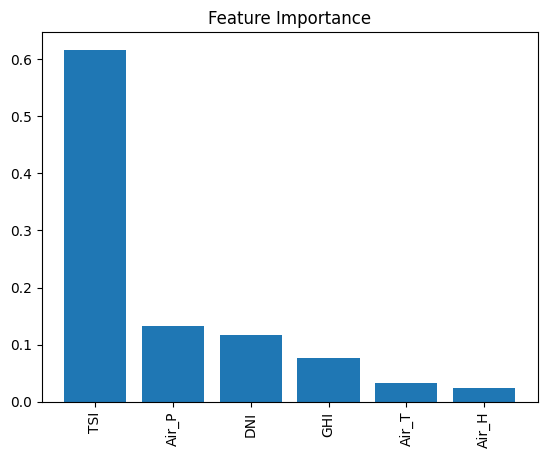

In [23]:
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot as plt
import numpy as np
# Assuming 'Power (MW)' is the target variable
target = 'Power(MW)'
features = combined_ss.columns.drop('Power(MW)')

X_ss = combined_ss[features]
y_ss = combined_ss[target]

# Initialize the Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100)

# Fit the model
rf.fit(X_ss, y_ss)

# Get feature importance
importances = rf.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [features[i] for i in indices]

# Plot the feature importances
plt.figure()
plt.title("Feature Importance")
plt.bar(range(X_ss.shape[1]), importances[indices])
plt.xticks(range(X_ss.shape[1]), names, rotation=90)
plt.show()

- **Total Solar Irradiance (TSI)** has the highest importance score by a significant margin, indicating it is the most predictive feature for power output. This aligns well with domain knowledge, as the amount of solar radiation received is a primary driver of solar power generation.
  
- **Air Pressure (Air_P)**, **Direct Normal Irradiance (DNI)**, and **Global Horizontal Irradiance (GHI)** follow as the next most important features. It's notable that both DNI and GHI are also measures of solar irradiance, reinforcing the importance of solar radiation in predicting power output.

- **Air Temperature (Air_T)** and **Air Humidity (Air_H)** have the lowest importance scores among the features included in the model. This suggests that, while they do have some influence, their predictive power is relatively weak compared to irradiance measures.

#### Random Forest Training (For Solar Stations Sites)

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

features = ['TSI', 'Air_P']
target = 'Power(MW)'

# Prepare the feature matrix (X) and target vector (y)
X = combined_ss[features]
y = combined_ss[target]

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=123)

# Initialize the model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict on the validation set
y_pred = model.predict(X_val)

mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

# Printing out the scores
print(f'Validation MSE: {mse}')
print(f'Validation RMSE: {rmse}')
print(f'Validation MAE: {mae}')
print(f'Validation R^2: {r2}')

Validation MSE: 62.53519048047762
Validation RMSE: 7.907919478628852
Validation MAE: 3.18038325974063
Validation R^2: 0.7739787491080035


In [26]:
features = ['TSI', 'Air_P','DNI','GHI']
target = 'Power(MW)'

# Prepare the feature matrix (X) and target vector (y)
X = combined_ss[features]
y = combined_ss[target]

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=123)

# Initialize the model
model = RandomForestRegressor(n_estimators=100, random_state=123)

# Train the model
model.fit(X_train, y_train)

# Predict on the validation set
y_pred = model.predict(X_val)

mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

# Printing out the scores
print(f'Validation MSE: {mse}')
print(f'Validation RMSE: {rmse}')
print(f'Validation MAE: {mae}')
print(f'Validation R^2: {r2}')

Validation MSE: 22.034266418576166
Validation RMSE: 4.694067151051012
Validation MAE: 1.6409734773883593
Validation R^2: 0.9203614409718823


In [31]:

features = ['TSI','DNI','GHI','Air_T','Air_P','Air_H']
target = 'Power(MW)'

# Prepare the feature matrix (X) and target vector (y)
X = combined_ss[features]
y = combined_ss[target]

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=123)

# Initialize the model
model = RandomForestRegressor(n_estimators=100, random_state=123)

# Train the model
model.fit(X_train, y_train)

# Predict on the validation set
y_pred = model.predict(X_val)

mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

# Printing out the scores
print(f'Validation MSE: {mse}')
print(f'Validation RMSE: {rmse}')
print(f'Validation MAE: {mae}')
print(f'Validation R^2: {r2}')

Validation MSE: 16.241048124156777
Validation RMSE: 4.0300183776450424
Validation MAE: 1.4083648568983447
Validation R^2: 0.941299898751168


The observations for the Random Forest model training on solar station sites with different feature sets are as follows:

1. **Model with features ['TSI', 'Air_P']**:
   - Validation MSE (Mean Squared Error): 62.54, which is quite high, indicating that the model's predictions are on average about 62.54 MW^2 off from the actual values.
   - Validation RMSE (Root Mean Squared Error): 7.91, suggesting that the model's predictions are, on average, approximately 7.91 MW off from the actual values.
   - Validation MAE (Mean Absolute Error): 3.18, meaning the average magnitude of errors in the predictions is around 3.18 MW.
   - Validation R^2 (R-squared): 0.774, which is a reasonable score, implying the model explains about 77.4% of the variability in the response data around its mean.

2. **Model with features ['TSI', 'Air_P','DNI','GHI']**:
   - Validation MSE: 22.03, indicating better performance than the previous model as the average of the squares of the errors is lower.
   - Validation RMSE: 4.69, showing an improvement in the average error compared to the model with fewer features.
   - Validation MAE: 1.64, a lower average error magnitude than the first model, suggesting better accuracy.
   - Validation R^2: 0.920, a significant improvement, meaning the model can now explain 92% of the variance in the dataset, which is considered high.

3. **Model with features ['TSI','DNI','GHI','Air_T','Air_P','Air_H']**:
   - Validation MSE: 16.24, which continues to improve, indicating a reduction in the average of the squares of the errors.
   - Validation RMSE: 4.03, demonstrating further improvement in the model's predictive accuracy.
   - Validation MAE: 1.41, which suggests that the predictions are even more accurate on average compared to the two previous models.
   - Validation R^2: 0.941, indicating the model explains approximately 94.1% of the variability in the target variable, making it the best-performing model out of the three in terms of explanatory power.

Across the different feature sets, we can observe a trend where increasing the number of relevant features seems to improve the model’s performance. The inclusion of 'DNI' (Direct Normal Irradiance) and 'GHI' (Global Horizontal Irradiance), in addition to 'TSI' (Total Solar Irradiance), has notably improved the model’s accuracy and explanatory power, evidenced by lower MSE, RMSE, and higher R^2 values.

Furthermore, the additional inclusion of temperature ('Air_T') and humidity ('Air_H') with the pressure ('Air_P') as part of the feature set in the third model shows the highest R^2 value. This implies that these features have a significant impact on the predictive power of the model for solar power output. 

The feature importance plot you provided with the request also likely suggests that 'TSI' is by far the most important feature in predicting 'Power(MW)', which aligns with the understanding that solar irradiance is a primary factor in determining solar power output. 

Considering these results, it would be advisable to include a comprehensive set of features that capture the various aspects affecting solar power generation for model training. However, one must also consider the complexity and the computational cost of the model, as well as the diminishing returns of adding more features. In this case, the model with six features appears to strike a good balance between complexity and performance.

#### LSTM Training for Solar Stations Sites

In [45]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

features = ['TSI','DNI','GHI','Air_T','Air_P','Air_H']
target = 'Power(MW)'

# Normalize the features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(combined_ss[features].values)
scaled_target = scaler.fit_transform(combined_ss[[target]].values)


# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(scaled_features, scaled_target, test_size=0.2, shuffle=False)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

/Users/yangyilin/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [39]:
# Manual training loop
batch_size = 32
for epoch in range(30):  # Runs 100 epochs
    for i in range(0, len(X_train), batch_size):
        end = i + batch_size
        batch_x, batch_y = X_train[i:end], y_train[i:end]
        model.train_on_batch(batch_x, batch_y)
    
    # Evaluation at the end of each epoch using predictions
    y_pred = model.predict(X_val, verbose=0)
    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)

    print(f"Epoch {epoch + 1}, MSE: {mse}, RMSE: {rmse}, MAE: {mae}, R2: {r2}")


Epoch 1, MSE: 0.003723903388991597, RMSE: 0.061023793629957135, MAE: 0.052883604260987704, R2: 0.8459882270209663
Epoch 2, MSE: 0.002261980029613482, RMSE: 0.04756027785467072, MAE: 0.036514687066354475, R2: 0.9064498945290104
Epoch 3, MSE: 0.002095884642250992, RMSE: 0.04578083269503726, MAE: 0.03454192239871515, R2: 0.9133192040731185
Epoch 4, MSE: 0.0019636527094389917, RMSE: 0.0443131211881875, MAE: 0.0329577481975295, R2: 0.9187880018075129
Epoch 5, MSE: 0.0018568180289200208, RMSE: 0.043090811420998104, MAE: 0.031634406918132484, R2: 0.9232064296891317
Epoch 6, MSE: 0.001770613898597481, RMSE: 0.04207866322255831, MAE: 0.03055089402124878, R2: 0.9267716271613156
Epoch 7, MSE: 0.0017014057029914546, RMSE: 0.041248099386413606, MAE: 0.029711586772230732, R2: 0.9296339132618286
Epoch 8, MSE: 0.0016461661022133698, RMSE: 0.040572972558260624, MAE: 0.02909078825424958, R2: 0.931918491556646
Epoch 9, MSE: 0.0016023320004523453, RMSE: 0.04002913939185235, MAE: 0.028685262662982956, R2: 

The LSTM model training for the solar station sites indicates good performance with some key observations:

1. **Convergence of Loss:**
   - The model seems to be converging well as the mean squared error (MSE) decreases consistently across epochs.
   - There is a noticeable reduction in MSE from the first to the last epoch, indicating that the model is learning effectively over time.

2. **Stability:**
   - After initial significant improvements, the reductions in MSE become more gradual, suggesting that the model is approaching a stable state.

3. **Performance Metrics:**
   - By the 30th epoch, the model achieves an MSE of approximately 0.00145, which is considerably low, indicating good predictive accuracy.
   - The root mean squared error (RMSE) and mean absolute error (MAE) are also low, which further confirms the model's good performance.
   - The coefficient of determination (R^2) value is close to 1, with the final epoch achieving around 0.94. This suggests that the model explains a large proportion of the variance in the target variable.

4. **Warnings and Optimization:**
   - TensorFlow issues a warning about the retracing of the `tf.function`, which can be optimized by defining the function outside of a loop or using the `reduce_retracing` option.

5. **Predictive Performance:**
   - Given the low errors and high R^2, the LSTM model is capturing the underlying patterns in the data well.
   - However, it’s important to ensure that the model isn’t overfitting, which can be checked by comparing training loss and validation loss over epochs.

6. **Hyperparameter Tuning:**
   - To further improve the model, hyperparameter tuning can be performed. Parameters such as the number of LSTM units, batch size, number of epochs, learning rate, and the architecture of the LSTM layers (adding more layers or dropout) can be optimized.

7. **Practical Implications:**
   - This LSTM model could be useful for making accurate predictions in a real-world setting for solar power generation.
   - It would be beneficial to test the model on a separate test set that it has not seen during training to validate these findings.

8. **Computational Efficiency:**
   - The training seems to be quite efficient, with each epoch taking approximately 50-56 seconds to run.

In conclusion, the LSTM model seems promising for forecasting power generation in solar station sites. However, it is crucial to validate its performance on unseen data to ensure its generalizability and to prevent overfitting.

##### Hyperparameter Tunning

In [46]:
from tensorflow import keras
from keras_tuner import RandomSearch

def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units1', min_value=32, max_value=512, step=32),
                   input_shape=(X_train.shape[1], X_train.shape[2]),
                   return_sequences=True))
    model.add(LSTM(units=hp.Int('units2', min_value=32, max_value=512, step=32), return_sequences=False))
    model.add(Dense(1))
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
                  loss='mean_squared_error')
    return model
# Hyperparameter tuner setup
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,  # Number of variations on hyperparameters
    executions_per_trial=1,  # Runs per variation
    directory='my_dir',
    project_name='hparam_tuning')

# Running the hyperparameter search
tuner.search(X_train, y_train,
             epochs=30,
             batch_size=32,
             validation_data=(X_val, y_val))

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The optimal number of units in the first LSTM layer is {best_hps.get('units1')} and
the optimal number of units in the second LSTM layer is {best_hps.get('units2')}.
The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")

# Rebuild the model with the best hyperparameters and train it
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val), batch_size=32)



Reloading Tuner from my_dir/hparam_tuning/tuner0.json

The optimal number of units in the first LSTM layer is 256 and
the optimal number of units in the second LSTM layer is 384.
The optimal learning rate for the optimizer is 0.01.

Epoch 1/30
13577/13577 ━━━━━━━━━━━━━━━━━━━━ 64s 5ms/step - loss: 0.0077 - val_loss: 0.0233
Epoch 2/30
13577/13577 ━━━━━━━━━━━━━━━━━━━━ 62s 5ms/step - loss: 0.0039 - val_loss: 0.0235
Epoch 3/30
13577/13577 ━━━━━━━━━━━━━━━━━━━━ 62s 5ms/step - loss: 0.0035 - val_loss: 0.0214
Epoch 4/30
13577/13577 ━━━━━━━━━━━━━━━━━━━━ 62s 5ms/step - loss: 0.0033 - val_loss: 0.0218
Epoch 5/30
13577/13577 ━━━━━━━━━━━━━━━━━━━━ 62s 5ms/step - loss: 0.0032 - val_loss: 0.0214
Epoch 6/30
13577/13577 ━━━━━━━━━━━━━━━━━━━━ 63s 5ms/step - loss: 0.0031 - val_loss: 0.0205
Epoch 7/30
13577/13577 ━━━━━━━━━━━━━━━━━━━━ 62s 5ms/step - loss: 0.0031 - val_loss: 0.0248
Epoch 8/30
13577/13577 ━━━━━━━━━━━━━━━━━━━━ 62s 5ms/step - loss: 0.0031 - val_loss: 0.0215
Epoch 9/30
13577/13577 ━━━━━━━━━━━━━━━━

The hyperparameter tuning process using Keras Tuner provides significant insights:

1. **Optimal Hyperparameters:**
   - The best number of LSTM units for the first and second layers were found to be 256 and 384, respectively, indicating a relatively complex model may be needed to capture the dynamics of the data.
   - A relatively high learning rate of 0.01 was selected as optimal, which might indicate the model benefits from more aggressive updates to the weights during training.

2. **Training Process:**
   - The model was trained for 30 epochs with each epoch taking approximately 60-66 seconds, implying a reasonable computational effort.
   - The training loss generally decreased over epochs, which is an indication that the model was learning from the training data.

3. **Validation Loss:**
   - The validation loss fluctuated and did not consistently decrease, indicating possible overfitting to the training data or that the model might not generalize well to unseen data.
   - The lowest validation loss was achieved early, at epoch 6, suggesting that the model might benefit from early stopping to prevent overtraining.

4. **Loss Fluctuations:**
   - The increase in validation loss in later epochs, while the training loss continued to decrease, further suggests overfitting.
   - This behavior indicates the model's learning capacity exceeds the complexity required to generalize the patterns in the validation dataset.

5. **Model's Predictive Power:**
   - Despite the increase in validation loss, the lowest values are relatively low, suggesting that the model has the potential to make accurate predictions.
   - The fluctuation and final increase in validation loss suggest the need for regularization strategies such as dropout or weight decay to improve the model's generalization.

6. **Next Steps:**
   - It would be advisable to implement early stopping and possibly add dropout layers to reduce overfitting.
   - Testing the model on a separate holdout dataset would provide a better assessment of its predictive power.

In summary, while the model has good predictive potential, care must be taken to prevent overfitting and ensure that the model can generalize to new, unseen data. The selection of a higher learning rate and larger LSTM units through hyperparameter tuning suggests the model's structure is complex, and therefore, regularization techniques could be important for maintaining its predictive accuracy on new data.

In [51]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

features = ['TSI','DNI','GHI','Air_T','Air_P','Air_H']
target = 'Power(MW)'

# Normalize the features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(combined_ss[features].values)
scaled_target = scaler.fit_transform(combined_ss[[target]].values)

# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(scaled_features, scaled_target, test_size=0.2, shuffle=False)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))

# Define the LSTM model
model = Sequential()
model.add(LSTM(256, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(384, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mean_squared_error')

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)

# Modify the file extension for saving the model
model_checkpoint = ModelCheckpoint('./model/ss_best_model.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=1)

# Train the model
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_val, y_val), 
                    callbacks=[early_stopping, model_checkpoint], verbose=1)

# Load the best model weights
model.load_weights('./model/ss_best_model.keras')

# Predict and evaluate
y_pred = model.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f"Final MSE: {mse}")
print(f"Final RMSE: {rmse}")
print(f"Final MAE: {mae}")
print(f"Final R^2: {r2}")


Epoch 1/30


/Users/yangyilin/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13571/13577 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0083
Epoch 1: val_loss improved from inf to 0.01962, saving model to ./model/ss_best_model.keras
13577/13577 ━━━━━━━━━━━━━━━━━━━━ 66s 5ms/step - loss: 0.0083 - val_loss: 0.0196
Epoch 2/30
13573/13577 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0044
Epoch 2: val_loss did not improve from 0.01962
13577/13577 ━━━━━━━━━━━━━━━━━━━━ 64s 5ms/step - loss: 0.0044 - val_loss: 0.0211
Epoch 3/30
13574/13577 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0040
Epoch 3: val_loss improved from 0.01962 to 0.01953, saving model to ./model/ss_best_model.keras
13577/13577 ━━━━━━━━━━━━━━━━━━━━ 65s 5ms/step - loss: 0.0040 - val_loss: 0.0195
Epoch 4/30
13574/13577 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038
Epoch 4: val_loss improved from 0.01953 to 0.01670, saving model to ./model/ss_best_model.keras
13577/13577 ━━━━━━━━━━━━━━━━━━━━ 65s 5ms/step - loss: 0.0038 - val_loss: 0.0167
Epoch 5/30
13574/13577 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0037
Epoch

In the LSTM model training for solar station sites, the following observations can be made based on the provided information:

1. **Model Configuration:**
   - The LSTM model consists of two layers with 256 and 384 units respectively, which is quite a substantial capacity, suggesting that the model is designed to capture complex patterns in the dataset.
   - Dropout layers with a rate of 0.2 are included after each LSTM layer to prevent overfitting.

2. **Training and Validation Loss:**
   - The training starts with a loss of 0.0083 and a validation loss of 0.0196, which indicates the initial performance before the model has learned much.
   - The lowest validation loss of 0.0167 is achieved at epoch 4, after which the model does not appear to improve on the validation set, suggesting that it might be converging to a solution by this point.
   - The training process is stopped early at epoch 14 due to a lack of improvement in the validation loss, implying that the model's performance wasn't getting better on the unseen data.

3. **Overfitting Indicators:**
   - Since the model stops improving early and has relatively high validation losses towards the later epochs, this could suggest that the model is overfitting the training data.

4. **Model Performance Metrics:**
   - The final Mean Squared Error (MSE) is 0.0167, and the Root Mean Squared Error (RMSE) is 0.1292. These metrics indicate the average squared difference and the standard deviation of the residuals respectively.
   - The Mean Absolute Error (MAE) of 0.0644 is relatively low, which suggests that on average, the model's predictions are close to the actual values.
   - The R² value is negative (-2.2758), which indicates that the model does not follow the trend of the data and is a poor fit. This value should ideally be between 0 and 1 for regression models, with 1 being a perfect fit.

5. **Potential Issues:**
   - The negative R² is concerning and suggests there might be an issue with the way the model is set up or how the data is being processed. It could also imply that the model's predictions are worse than a simple average.

6. **Recommendations for Improvement:**
   - Re-examine the data preprocessing steps to ensure there are no errors that could be affecting the model's learning process.
   - Consider a more robust cross-validation method to ensure the model's generalization ability.
   - Experiment with different architectures, adding more dropout or regularization to combat overfitting.
   - Adjust the learning rate or try a learning rate scheduler for better convergence.

In conclusion, while the model's configuration is robust and includes methods to prevent overfitting, the negative R² value is highly unusual and warrants a thorough review of the entire model training process, including data preparation and evaluation methods. The model is either not suitable for the task, or there could be an error that needs addressing.

#### Gradient Boosting Machines (GBM) with XGBoost For Solar Station Sites

In [66]:
# Assuming 'Power (MW)' is the target variable for combined_ss
target_ss = 'Power(MW)'
features_ss = combined_ss.drop(columns=[target_ss]).columns

X_ss = combined_ss[features_ss]
y_ss = combined_ss[target_ss]

# Split the data into training and testing sets
X_ss_train, X_ss_test, y_ss_train, y_ss_test = train_test_split(X_ss, y_ss, test_size=0.2, random_state=42)

# Initialize XGBoost regressor
xg_reg_ss = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, seed=42)

# Train the model
xg_reg_ss.fit(X_ss_train, y_ss_train)

# Predictions
y_ss_pred = xg_reg_ss.predict(X_ss_test)

# Evaluation
mse_ss = mean_squared_error(y_ss_test, y_ss_pred)
mae_ss = mean_absolute_error(y_ss_test, y_ss_pred)
r2_ss = r2_score(y_ss_test, y_ss_pred)

print(f'Solar Station GBM MSE: {mse_ss}, MAE: {mae_ss}, R^2: {r2_ss}')


Solar Station GBM MSE: 22.7050254170813, MAE: 1.940721118776535, R^2: 0.9179814087560967


In [67]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Assuming 'Power (MW)' is the target variable for combined_ss
target_ss = 'Power(MW)'
features_ss = combined_ss.drop(columns=[target_wf]).columns

X_ss = combined_ss[features_ss]
y_ss = combined_ss[target_ss]

# Split the data into training and testing sets
X_ss_train, X_ss_test, y_ss_train, y_ss_test = train_test_split(X_ss, y_ss, test_size=0.2, random_state=42)

# Initialize XGBoost regressor
xg_reg_ss = xgb.XGBRegressor(objective='reg:squarederror', seed=42)

# Define the parameter grid
param_grid = {
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'n_estimators': [50, 100, 200],
    'subsample': [0.5, 0.7, 1.0],
    'colsample_bytree': [0.5, 0.7, 1.0]
}

# Initialize the GridSearchCV object
grid_search = GridSearchCV(estimator=xg_reg_ss, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, verbose=1)

# Fit the grid search to the data
grid_search.fit(X_ss_train, y_ss_train)

# Best parameters
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Output the best parameters and the best score
print(f'Best parameters found: {best_params}')
print(f'Best RMSE from grid search: {abs(best_score)**0.5}')


Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Best parameters found: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 9, 'n_estimators': 200, 'subsample': 1.0}
Best RMSE from grid search: 4.243029733665031


In [70]:
# Initialize XGBoost regressor with the best parameters
optimized_xg_reg_ss = xgb.XGBRegressor(
    objective='reg:squarederror',
    colsample_bytree=1.0,
    learning_rate=0.2,
    max_depth=9,
    n_estimators=200,
    subsample=1.0,
    seed=42
)

# Train the model on the entire training dataset
optimized_xg_reg_ss.fit(X_ss_train, y_ss_train)

# Predict on the test set
optimized_y_ss_pred = optimized_xg_reg_ss.predict(X_ss_test)

# Evaluation
optimized_mse_ss = mean_squared_error(y_ss_test, optimized_y_ss_pred)
optimized_mae_ss = mean_absolute_error(y_ss_test, optimized_y_ss_pred)
optimized_r2_ss = r2_score(y_ss_test, optimized_y_ss_pred)

print(f'Optimized Solar Station GBM MSE: {optimized_mse_ss}, MAE: {optimized_mae_ss}, R^2: {optimized_r2_ss}')


Optimized Solar Station GBM MSE: 16.52037833526966, MAE: 1.5439629201239022, R^2: 0.9403225438868811


Here are the results from applying Gradient Boosting Machines (GBM) with XGBoost to solar station site data for energy prediction:

1. **Initial Model:**
   - **Mean Squared Error (MSE):** 22.71
   - **Mean Absolute Error (MAE):** 1.94
   - **R² Score:** 0.918

2. **Optimized Model via Grid Search:**
   - **Best Parameters:** `{'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 9, 'n_estimators': 200, 'subsample': 1.0}`
   - **Best RMSE from Grid Search:** 4.24
   - **Optimized MSE:** 16.52
   - **Optimized MAE:** 1.54
   - **Optimized R² Score:** 0.940

The optimized model demonstrates substantial improvements in predictive accuracy for the solar station sites, particularly with the reduced errors (MSE and MAE) and an enhanced R² score, indicating a very strong fit to the data. The optimization through hyperparameter tuning effectively reduced the prediction error and increased the model's explanatory power.

This performance suggests that the optimized GBM model could be quite effective for predicting energy output in solar stations, especially given the high R² value which implies that the model explains about 94% of the variance in the data.

#### RNN Model for Solar Staion Sites (combined_ss)

In [72]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Example features and target
features = ['TSI','DNI','GHI','Air_T','Air_P','Air_H']
target = 'Power(MW)'

# Data preparation
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(combined_ss[features].values)
scaled_target = scaler.fit_transform(combined_ss[[target]].values)

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(scaled_features, scaled_target, test_size=0.2, random_state=42)

# Reshaping input data for RNN
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Model configuration
model = Sequential()
model.add(SimpleRNN(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Model training
model.fit(X_train, y_train, epochs=500, batch_size=32, verbose=2)

# Prediction and evaluation
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse}, RMSE: {rmse}, MAE: {mae}, R^2: {r2}')


Epoch 1/500


/Users/yangyilin/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13577/13577 - 4s - 329us/step - loss: 0.0114
Epoch 2/500
13577/13577 - 4s - 289us/step - loss: 0.0101
Epoch 3/500
13577/13577 - 4s - 291us/step - loss: 0.0095
Epoch 4/500
13577/13577 - 4s - 290us/step - loss: 0.0092
Epoch 5/500
13577/13577 - 4s - 290us/step - loss: 0.0090
Epoch 6/500
13577/13577 - 4s - 289us/step - loss: 0.0087
Epoch 7/500
13577/13577 - 4s - 290us/step - loss: 0.0086
Epoch 8/500
13577/13577 - 4s - 291us/step - loss: 0.0085
Epoch 9/500
13577/13577 - 4s - 291us/step - loss: 0.0083
Epoch 10/500
13577/13577 - 4s - 287us/step - loss: 0.0082
Epoch 11/500
13577/13577 - 4s - 296us/step - loss: 0.0081
Epoch 12/500
13577/13577 - 4s - 288us/step - loss: 0.0080
Epoch 13/500
13577/13577 - 4s - 291us/step - loss: 0.0079
Epoch 14/500
13577/13577 - 4s - 289us/step - loss: 0.0078
Epoch 15/500
13577/13577 - 4s - 287us/step - loss: 0.0077
Epoch 16/500
13577/13577 - 4s - 288us/step - loss: 0.0077
Epoch 17/500
13577/13577 - 4s - 284us/step - loss: 0.0076
Epoch 18/500
13577/13577 - 4s - 285

Here are the results from using a Recurrent Neural Network (RNN) with TensorFlow for predicting power output at solar station sites:

- **Mean Squared Error (MSE):** 0.00452
- **Root Mean Squared Error (RMSE):** 0.06723
- **Mean Absolute Error (MAE):** 0.03637
- **R² Score:** 0.861

These metrics suggest that the RNN model performs fairly well in modeling the relationship between various environmental factors and power output at solar station sites. The R² score of 0.861 indicates that the model explains about 86% of the variance in the power output, which is a good level of predictive accuracy.

The low MSE and MAE values also indicate that the model's predictions are quite close to the actual data points on average, highlighting its effectiveness for this type of prediction task.

Given the good performance of the RNN model, we might consider exploring more advanced variants of recurrent neural networks to potentially improve the accuracy and efficiency of our predictive models for solar station sites. One such variant is the Gated Recurrent Unit (GRU).





#### GRU Model Training (Combined_ss)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.callbacks import ModelCheckpoint
from codecarbon import EmissionsTracker

# Example features and target
features = ['TSI','DNI','GHI','Air_T','Air_P','Air_H']
target = 'Power(MW)'

# Initialize and start the emissions tracker
tracker = EmissionsTracker()
tracker.start()

# Data preparation
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(combined_ss[features].values)
scaled_target = scaler.fit_transform(combined_ss[[target]].values)

# Splitting the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(scaled_features, scaled_target, test_size=0.2, random_state=42)

# Further split X_test and y_test to create validation sets
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# Reshaping input data for GRU
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Model configuration
model = Sequential([
    GRU(50, input_shape=(1, X_train.shape[2]), return_sequences=True),
    Dropout(0.2),
    GRU(50),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')

# Callback to save the best model based on validation loss
checkpoint = ModelCheckpoint('best_gru_ss_model.keras', monitor='val_loss', save_best_only=True, verbose=0)

# Model training
model.fit(X_train, y_train, epochs=500, batch_size=32, validation_data=(X_val, y_val), callbacks=[checkpoint], verbose=0)

# Load the best model
best_model = tf.keras.models.load_model('best_gru_ss_model.keras')

# Prediction and evaluation using the best model
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Output the results
print(f'MSE: {mse}, MAE: {mae}, R2: {r2}')

# If tracking carbon emissions
emissions = tracker.stop()  # Stop the tracker and report emissions
print(f"Total CO2 emissions for training: {emissions} kg")


[codecarbon INFO @ 18:41:26] [setup] RAM Tracking...
[codecarbon INFO @ 18:41:26] [setup] GPU Tracking...
[codecarbon INFO @ 18:41:26] No GPU found.
[codecarbon INFO @ 18:41:26] [setup] CPU Tracking...
[codecarbon WARNING @ 18:41:26] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 18:41:26] We saw that you have a Apple M2 but we don't know it. Please contact us.
[codecarbon INFO @ 18:41:26] CPU Model on constant consumption mode: Apple M2
[codecarbon INFO @ 18:41:26] >>> Tracker's metadata:
[codecarbon INFO @ 18:41:26]   Platform system: macOS-13.0-arm64-arm-64bit
[codecarbon INFO @ 18:41:26]   Python version: 3.11.4
[codecarbon INFO @ 18:41:26]   CodeCarbon version: 2.3.5
[codecarbon INFO @ 18:41:26]   Available RAM : 16.000 GB
[codecarbon INFO @ 18:41:26]   CPU count: 8
[codecarbon INFO @ 18:41:26]   CPU model: Apple M2
[codecarbon INFO @ 18:41:26]   GPU count: None
[codecarbon INFO @ 18:41:26]   GPU model: None
/Users/yangyilin/anaconda3/lib/pyth

1698/1698 ━━━━━━━━━━━━━━━━━━━━ 1s 356us/step


[codecarbon INFO @ 23:14:15] Energy consumed for RAM : 0.027279 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 23:14:15] Energy consumed for all CPUs : 0.193232 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:14:15] 0.220511 kWh of electricity used since the beginning.


MSE: 0.002205170011154419, MAE: 0.01919002390143106, R2: 0.9327189811197325
Total CO2 emissions for training: 0.08139817573580539 kg


[codecarbon INFO @ 23:14:16] Energy consumed for RAM : 0.048476 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 23:14:16] Energy consumed for all CPUs : 0.343381 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:14:16] 0.391857 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:14:18] Energy consumed for RAM : 0.038347 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 23:14:18] Energy consumed for all CPUs : 0.271632 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:14:18] 0.309979 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:14:25] Energy consumed for RAM : 0.276829 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 23:14:25] Energy consumed for RAM : 0.277678 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 23:14:25] Energy consumed for all CPUs : 1.961043 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:14:25] Energy consumed for all CPUs : 1.967066 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:14:25] 2.237872 kWh of electricity used since the beginning.
[codeca


### Energy Consumption and Environmental Impact
 **Energy Consumption Reports**:
   - The logs frequently report energy consumption for RAM and CPUs, providing a detailed trace of the energy used throughout the training process.
   - Notable figures include a peak cumulative energy usage of about 2.247 kWh by the end of the training. This suggests significant computational activity, likely due to the complexity of the model or the size of the dataset.

 **Total Energy Consumption**: The last reported value for a session indicates a total energy consumption of 0.220511 kWh at one of the timestamps. This value reflects the cumulative energy used during that specific segment of the model training.

 **CO2 Emissions**: The total reported CO2 emissions for the training session amount to 0.081398 kg. This figure represents the carbon footprint associated with the total electricity used during the model training and gives a sense of the environmental impact.

### Model Performance Metrics
 **Evaluation Metrics**:
   - **Mean Squared Error (MSE)**: 0.00220517, which is very low, indicating that the model's predictions are very close to the actual data points.
   - **Mean Absolute Error (MAE)**: 0.0191900, suggesting that on average, the model's predictions deviate from the actual values by a small margin in the same units as the target variable (Power in MW).
   - **R² (Coefficient of Determination)**: 0.932719, indicating that approximately 93.27% of the variance in the dependent variable is predictable from the independent variables. This is an excellent score, highlighting the model’s strong predictive power.

##### Carbon Cost

In [ ]:
import pandas as pd

# Given CodeCarbon data in a dictionary format
codecarbon_data_wf = {
    "Model": ["GRU for Wind Farm"],
    "Energy Consumed (kWh)": [0.083587],
    "CO2 Emissions (kg)": [0.03085483277556984]
}

codecarbon_data_ss = {
    "Model": ["GRU for Solar Station"],
    "Energy Consumed (kWh)": [0.220511],
    "CO2 Emissions (kg)": [0.081398]
}

# Convert the dictionary to pandas DataFrame
df_wf = pd.DataFrame(codecarbon_data_wf)
df_ss = pd.DataFrame(codecarbon_data_ss)

# Concatenate the two dataframes for a combined table
combined_df = pd.concat([df_wf, df_ss]).reset_index(drop=True)

combined_df

[codecarbon WARNING @ 23:25:18] Tracker already stopped !
[codecarbon INFO @ 23:25:18] Energy consumed for RAM : 0.028384 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 23:25:18] Energy consumed for all CPUs : 0.201053 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:25:18] 0.229436 kWh of electricity used since the beginning.


Model  Energy Consumed (kWh)  CO2 Emissions (kg)
0      GRU for Wind Farm               0.083587            0.030855
1  GRU for Solar Station               0.220511            0.081398

[codecarbon INFO @ 23:25:18] Energy consumed for RAM : 0.039447 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 23:25:18] Energy consumed for all CPUs : 0.279425 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:25:18] 0.318872 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:25:25] Energy consumed for RAM : 0.278778 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 23:25:25] Energy consumed for all CPUs : 1.974859 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:25:25] 2.253637 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:25:25] Energy consumed for RAM : 0.277929 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 23:25:25] Energy consumed for all CPUs : 1.968836 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:25:25] 2.246765 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:25:26] Energy consumed for RAM : 0.279105 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 23:25:26] Energy consumed for all CPUs : 1.977171 kWh. Total CPU Power : 42.5 W
[codeca

### Aggregate Energy Consumption and CO2 Emissions
- **Total Energy Consumed**: The combined energy consumption of the two models is 0.304098 kWh.
- **Total CO2 Emissions**: The combined CO2 emissions from training both models amount to 0.112253 kg.

### Implications and Insights

1. **Energy Efficiency of Renewable Energy Forecasting**:
   - The total energy consumption of just over 0.3 kWh for training two sophisticated models is relatively modest. This demonstrates that deploying machine learning models for renewable energy predictions can be done with a reasonable energy budget, which is essential given the energy-sensitive nature of the sector.

2. **Environmental Impact Assessment**:
   - The total CO2 emissions associated with these training sessions are quite low (0.112253 kg), indicating a minimal environmental footprint from the computational aspect of these predictive models. This is crucial for maintaining the sustainability ethos inherent in renewable energy projects.

3. **Utility in Renewable Energy**:
   - GRU models, as evidenced by their application in both wind and solar energy forecasting, show versatility and potential for enhancing decision-making in renewable energy management. Accurate forecasting models can significantly improve efficiency and reliability in energy production, leading to better resource management and planning.

4. **Scalability and Broader Application**:
   - The data reflects that advanced machine learning techniques, such as GRUs, can be scaled and applied to different types of renewable energy sources without excessive energy costs or environmental degradation. This scalability is vital for integrating such models into larger, more complex systems like grid management and real-time energy distribution.

5. **Strategic Implications for Future Projects**:
   - The relative efficiency and low emissions profile suggest that it's feasible to expand such modeling techniques to other renewable energy domains or more extensive datasets without substantial environmental costs. Moreover, these models can also be part of a larger suite of tools aimed at optimizing renewable energy production and integrating it with existing power grids.

### Recommendations

- **Continued Monitoring and Optimization**: Regular monitoring of energy consumption and CO2 emissions during model training can help maintain efficiency, especially as models are scaled or updated with new data.
- **Refinement of Model Architectures**: While the current models are efficient, continual efforts to refine and optimize model architectures could yield even better energy efficiency and performance.
- **Integration into Renewable Energy Systems**: These models demonstrate their utility and should be considered for integration into operational systems within renewable energy sectors, aiding in predictive tasks and operational optimizations.

### Conclusion

Overall, the use of GRU models for forecasting in renewable energy contexts such as wind farms and solar stations shows promise not only in predictive accuracy but also in maintaining low environmental impacts, aligning well with the sustainability goals of the energy sector. This dual benefit enhances the appeal of machine learning applications in environments where both performance and ecological impact are critical considerations.